# Students and Sections 2
[1. Introduction](#introduction)

[2. Preliminary data processing](#prelim)

[3. Summarizing the data](#sum)

[4. Standardizing the exam scores](#stand)

[5. Normality assumptions](#norm)

[6. Box plots of standardized scores](#box)

[7. Classical investigation of teacher influence](#teach)

[8. The influence of section numbering - Classical analysis](#sec)

[9. Three Bayseian models](#bayes)

[10. Revisiting the dropping of absents](#abs)

[11. Dropping year 5](#five)

[12. Model without teacher influence](#no_T)

[13. A model without section information](#no_sec)

[14. Conclusions](#conc)

<a id='introduction'></a>
## 1. Introduction
This notebook continues the investigation of student exam results from the previous notebook. The data here is of exam results from two exams in a mathematics course taken in the first year of undergrad. This data partially overlaps with the second year exam data of the previous notebook. The 1st year of the data here is the same cohort as the 2nd year of the data there. In this notebook we will examine only the data from these first year exams. A later notebook will combine the data for a more sophisticated analysis.  

A complicating factor for our analysis here is that different sections were taught by different teachers for different exams. Since teachers may in theory have an influence on student performance this needs to be accounted for in some way. Actually it turns out that none of the four teachers involved in this course performed significantly better or worse than the others, and the best (according to loo) Bayesian model we investigate doesn't use the teacher information. 

<a id='prelim'></a>
## 2. Preliminary data processing
This data covers 8 years of a compulsory mathematics course for first year undergraduates. Students are divided into 3 sections (officially numbered 1,2 and 3), except in year 5 when there were only 2 sections due to an unusually small student cohort. Each section was taught by a teacher (4 in total), with most of the teaching being done by two (here unofficially numbered 1 and 2).

In [1]:
library(loo)
library(rstan)
library(pwr)

# set number of years
num_years <- 8

# set number of iterations for Bayesian models
num_iters = 5000

data <- read.csv("students_teachers_anon.csv", header=TRUE, stringsAsFactors=FALSE)
df_base <- data.frame(data)
df_base$Midterm <- as.numeric(df_base$Midterm)
df_base$Final <- as.numeric(df_base$Final)
str(df_base)

This is loo version 2.5.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

- Windows 10 users: loo may be very slow if 'mc.cores' is set in your .Rprofile file (see https://github.com/stan-dev/loo/issues/94).

Loading required package: StanHeaders


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

'data.frame':	1457 obs. of  7 variables:
 $ Section  : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm  : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final    : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M: int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F: int  1 1 1 1 1 1 1 1 1 1 ...


We will drop students who did not take both exams (i.e. those who dropped out or withdrew before taking the final). This is not ideal as it throws away some information. Moreover, the chance a student drops out is likely influenced by their teacher. Both directly via the teacher's personality and guidance provided, but also indirectly as it seems plausible that students are more likely to drop out if their scores are expected to be low. Since we cannot predict the dropout risk from the other available data, our missing data here is, in technical terms, *missing not at random*, and thus omitting it is a source of potential bias. We will revisit this later, but for now we will take the simple approach.  

In [2]:
df <- df_base[ complete.cases(df_base$Midterm, df_base$Final) , ]
str(df)

'data.frame':	1388 obs. of  7 variables:
 $ Section  : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm  : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final    : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M: int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F: int  1 1 1 1 1 1 1 1 1 1 ...


In [3]:
df <- df[!df$Repeat == 1,]
str(df)

'data.frame':	1359 obs. of  7 variables:
 $ Section  : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm  : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final    : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M: int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F: int  1 1 1 1 1 1 1 1 1 1 ...


<a id='sum'></a>
## 3. Summarizing the data

In [4]:
library(dplyr)
d = df %>% group_by(Year) %>% summarise(total_students = length(Section), 
                                            total_S1 = sum(Section == 1),
                                            total_S2 = sum(Section == 2),
                                            total_S3 = sum(Section == 3),
                                            teacher_S1_M = mean(Teacher_M[Section==1]),
                                            teacher_S2_M = mean(Teacher_M[Section==2]),
                                            teacher_S3_M = mean(Teacher_M[Section==3]),
                                            overall_average_M = mean(Midterm),
                                            mean_M_S1 = mean(Midterm[Section == 1]),
                                            mean_M_S2 = mean(Midterm[Section == 2]),
                                            mean_M_S3 = mean(Midterm[Section == 3]),
                                            teacher_S1_F = mean(Teacher_F[Section==1]),
                                            teacher_S2_F = mean(Teacher_F[Section==2]),
                                            teacher_S3_F = mean(Teacher_F[Section==3]),
                                            overall_average_F = mean(Final),
                                            mean_F_S1 = mean(Final[Section == 1]),
                                            mean_F_S2 = mean(Final[Section == 2]),
                                            mean_F_S3 = mean(Final[Section == 3]))

d


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Year,total_students,total_S1,total_S2,total_S3,teacher_S1_M,teacher_S2_M,teacher_S3_M,overall_average_M,mean_M_S1,mean_M_S2,mean_M_S3,teacher_S1_F,teacher_S2_F,teacher_S3_F,overall_average_F,mean_F_S1,mean_F_S2,mean_F_S3
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,245,77,84,84,2,2,2,39.77143,51.11039,33.21429,35.93452,1,1,1,38.17959,47.55844,33.10714,34.65476
2,180,63,61,56,2,3,1,44.30278,58.28571,37.44262,36.04464,2,3,1,46.06833,64.04444,36.45902,36.31250
3,192,56,67,69,2,1,2,43.29688,56.22321,38.06716,37.88406,2,1,2,48.15104,60.56250,39.74627,46.23913
4,140,53,41,46,2,1,2,49.87143,63.46226,42.57317,40.71739,2,1,2,47.27143,59.48113,39.21951,40.38043
5,87,49,38,0,1,2,NaN,53.41954,64.89796,38.61842,NaN,1,2,NaN,47.89080,53.35714,40.84211,NaN
6,172,60,56,56,2,2,1,40.85756,43.50000,38.29464,40.58929,1,2,1,52.54680,54.52883,50.80375,52.16625
7,168,49,59,60,2,2,1,53.99226,55.90388,56.11339,50.34533,1,2,1,57.15417,58.53673,60.76949,52.47000
8,175,59,56,60,2,1,4,53.83029,55.69322,53.94643,51.89000,2,1,1,49.58571,51.37288,48.74821,48.61000


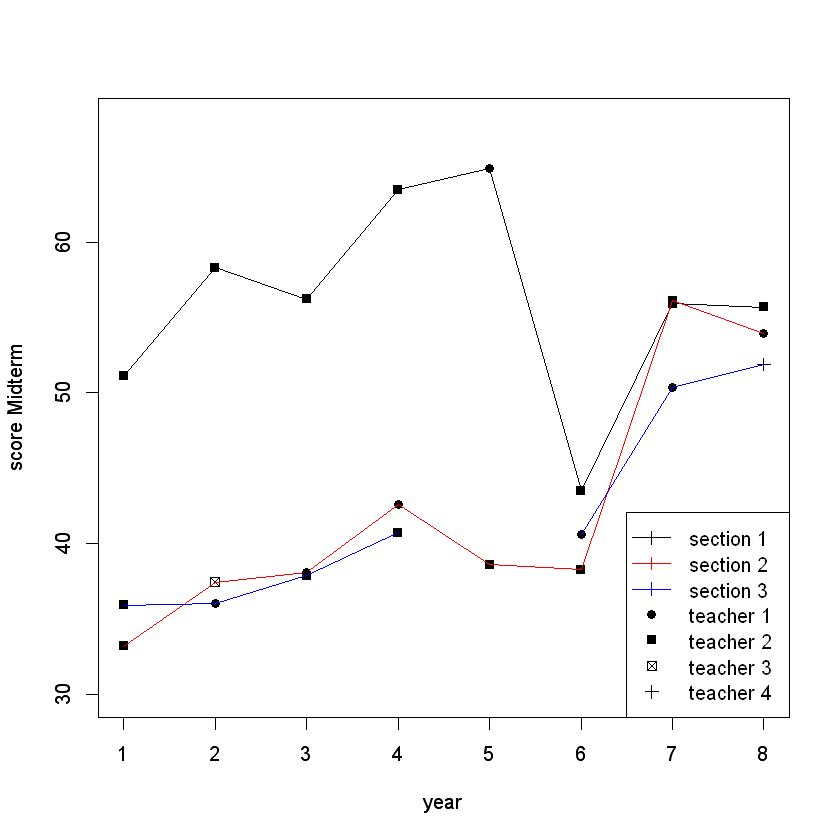

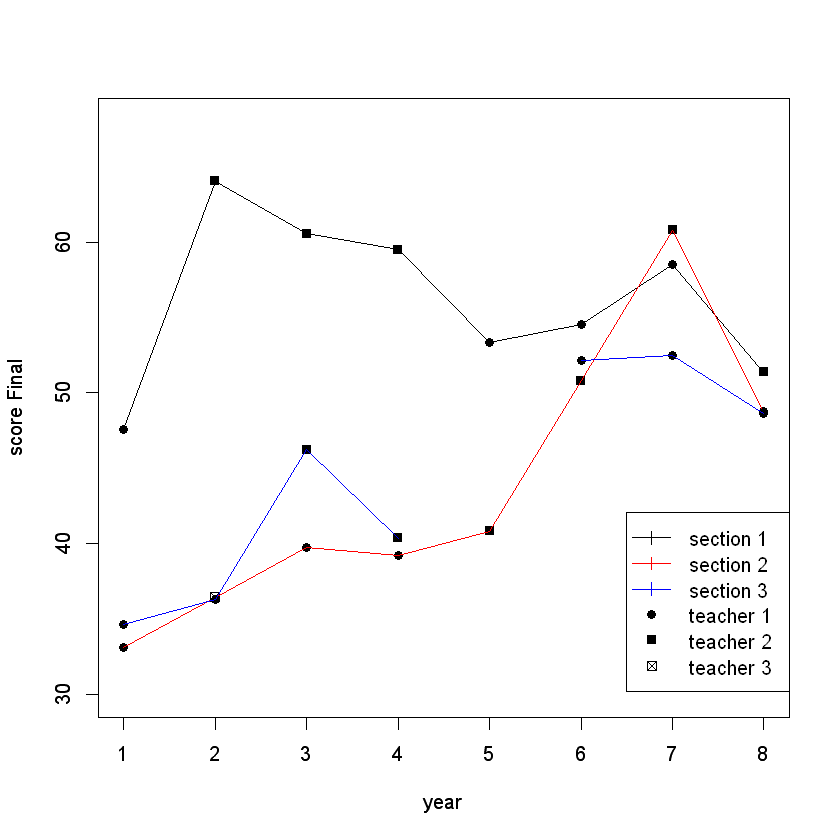

In [5]:
sections = list(d$mean_M_S1, d$mean_M_S2, d$mean_M_S3)
colours = c('black', 'red', 'blue')

d$s1_key_1 <- ifelse(d$teacher_S1_M == 1, 19, ifelse(d$teacher_S1_M == 2 , 15, ifelse(d$teacher_S1_M == 3, 7, 3)))
d$s2_key_1 <- ifelse(d$teacher_S2_M == 1, 19, ifelse(d$teacher_S2_M == 2 , 15, ifelse(d$teacher_S2_M == 3, 7, 3)))
d$s3_key_1 <- ifelse(d$teacher_S3_M == 1, 19, ifelse(d$teacher_S3_M == 2 , 15, ifelse(d$teacher_S3_M == 3, 7, 3)))
icons_1 <- list(d$s1_key_1, d$s2_key_1, d$s3_key_1) 

i = 1
for (section in sections)
{
    plot(d$Year, section, ylim=c(30,68), ylab = "score Midterm", xlab = 'year', pch = icons_1[[i]], col = 'black')
    lines(d$Year, section, ylim=c(30,68), ylab = "", col = colours[i])
    par(new = TRUE)
    i = i + 1
}

legend(6.5,42.1, lty = c(1,1,1,0,0,0,0), pch = c(3,3,3,19,15,7,3), 
       col = c("black", "red", "blue", "black", "black", "black", "black"),
       legend = c("section 1","section 2", "section 3",
                  "teacher 1", "teacher 2", "teacher 3", "teacher 4"))

sections = list(d$mean_F_S1, d$mean_F_S2, d$mean_F_S3)

d$s1_key_2 <- ifelse(d$teacher_S1_F == 1, 19, ifelse(d$teacher_S1_F == 2 , 15, ifelse(d$teacher_S1_F == 3, 7, 3)))
d$s2_key_2 <- ifelse(d$teacher_S2_F == 1, 19, ifelse(d$teacher_S2_F == 2 , 15, ifelse(d$teacher_S2_F == 3, 7, 3)))
d$s3_key_2 <- ifelse(d$teacher_S3_F == 1, 19, ifelse(d$teacher_S3_F == 2 , 15, ifelse(d$teacher_S3_F == 3, 7, 3)))
icons_2 <- list(d$s1_key_2, d$s2_key_2, d$s3_key_2)

i = 1
for (section in sections)
{
    plot(d$Year, section, ylim=c(30,68), ylab = "score Final", xlab = 'year', pch = icons_2[[i]], col = 'black')
    lines(d$Year, section, ylim=c(30,68), ylab = "", col = colours[i])
    par(new = TRUE)
    i = i + 1
}

legend(6.5,42.1, lty = c(1,1,1,0,0,0), pch = c(3,3,3,19,15,7), 
       col = c("black", "red", "blue", "black", "black", "black"),
       legend = c("section 1","section 2", "section 3",
                  "teacher 1", "teacher 2", "teacher 3"))

<a id='chart'></a>The charts above have some interesting features. First, there is a big jump in average scores in the 2nd exam of year 6. This coincides with Covid, with the 1st exam being the last to be taken in person, and the exams after being online. One possible reason for this is that the online exams were open book, but we won't investigate this here.

Another interesting thing is the performance of the Section 1 students. In years 1 to 4 Section 1 was academically selected, so their higher performance is understandable. But academic selection was abolished in year 5, but the Section 1 students perform significantly better than the section 2 students (there were only 2 sections this year due to a smaller intake). Even more curious, year 5 in this data corresponds to year 6 in the data I used to compare performance of sections. In that data section 1 performed worse than Section 2. Both courses involved are mathematics based, so what explains extremely high relative performance in this case?

The format for exams in this subject during years 1-5 is that they are divided into two halves, with each instructor setting half. While this is not in the publicly available data, it turns out that in year 5 Section one did significantly better in both halves of the exam. This is significant because it rules out the hypothesis that the higher performance of Section 1 was due to being given perhaps overly specific guidance by their instructor on the material that would appear in the corresponding half of the exam. 

## 4. Standardizing scores <a id='stand'></a>
For meaningful comparisons across years, exam scores will be standardized to give relative performance within year group. 

In [6]:
for (y in 1 : num_years){
  index <- df$Year == y
  m_1 <- mean(df$Midterm[index])
  m_2 <- mean(df$Final[index])  
  s_1 <- sd(df$Midterm[index])
  s_2 <- sd(df$Final[index])
  df$Midterm_std[index] <- ( df$Midterm[index] - m_1 )/s_1
  df$Final_std[index] <- ( df$Final[index] - m_2 )/s_2  
    }

str(df)

'data.frame':	1359 obs. of  9 variables:
 $ Section    : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm    : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final      : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std: num  1.932 1.329 -0.399 0.506 0.177 ...
 $ Final_std  : num  1.355 0.957 -0.522 0.957 0.843 ...


## 5. Normality assumptions <a id='norm'></a>

We will start with some simple t-tests. A background assumption for such tests to be valid is that the distributions are roughly normal. We can test this, first by drawing histograms from our data and looking at them, then by drawing Q-Q plots. Formal tests such as the Shapiro-Wilk test are likely to be unhelpful here, as they are generally regarded as being over-sensitive, in the sense that for reasonably large datasets they will reject normality, even when the deviation from normality does not significantly affect the test for which the assumption of normality is being made (such as, I believe, is the case here).

We exclude Section 1 for years 1-4 because these students were academically preselected.

In [7]:
index <- df$Section == 1 & (df$Year <= 4)

df_trimmed <- df[!index,]

str(df_trimmed)

'data.frame':	1110 obs. of  9 variables:
 $ Section    : int  3 2 3 3 3 2 2 3 2 3 ...
 $ Midterm    : num  64 32.5 49 43 42.5 72.5 50.5 53 27.5 23.5 ...
 $ Final      : num  55 29 55 53 47 58 41 9 32 34 ...
 $ Year       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std: num  1.329 -0.399 0.506 0.177 0.15 ...
 $ Final_std  : num  0.957 -0.522 0.957 0.843 0.502 ...


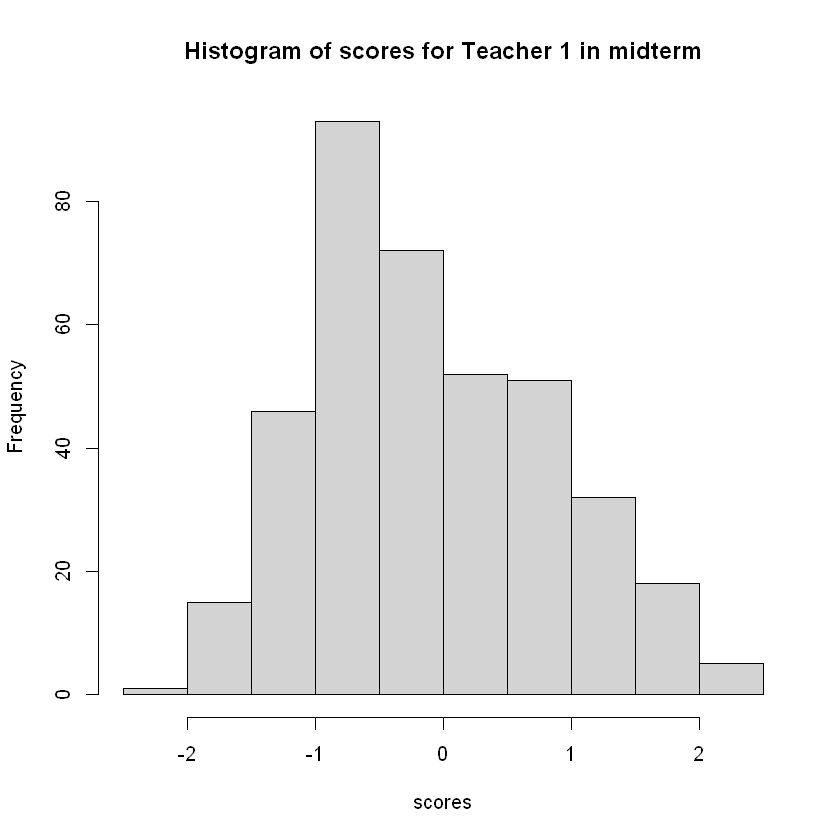

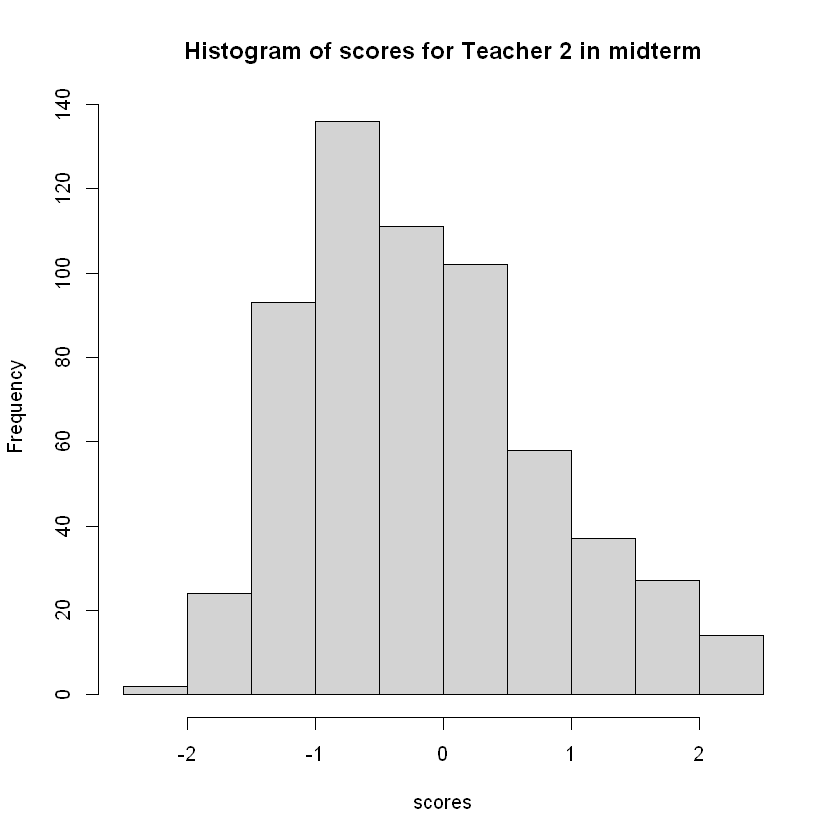

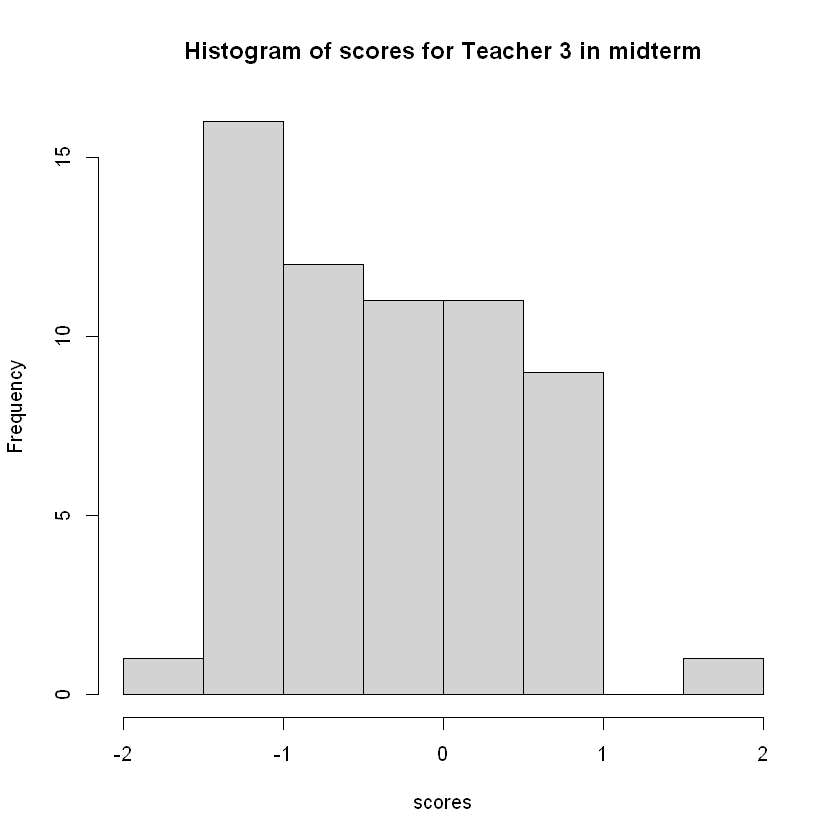

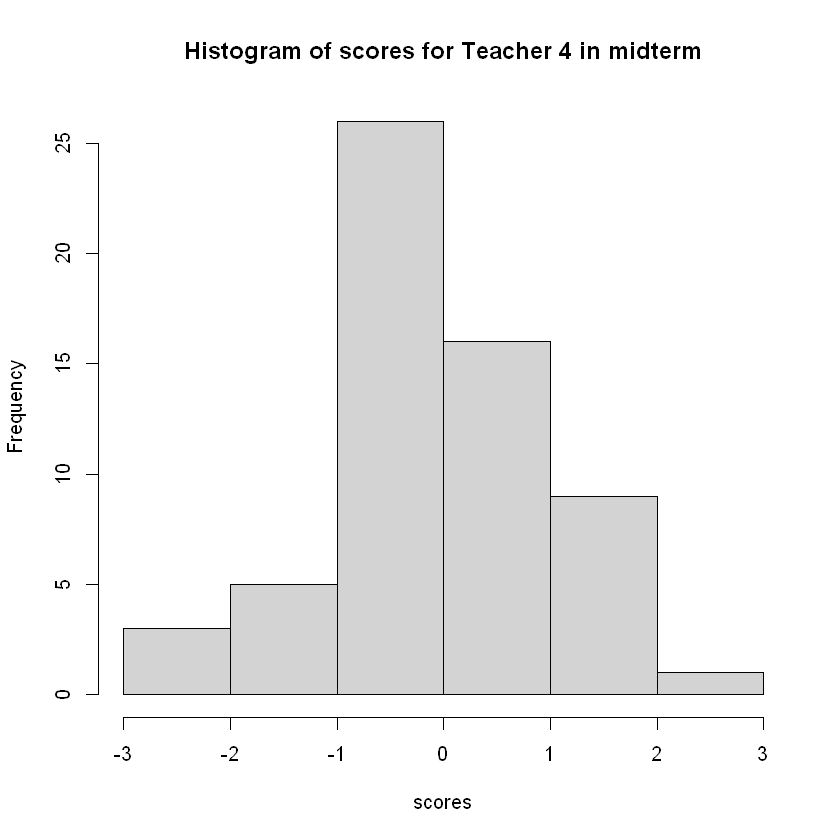

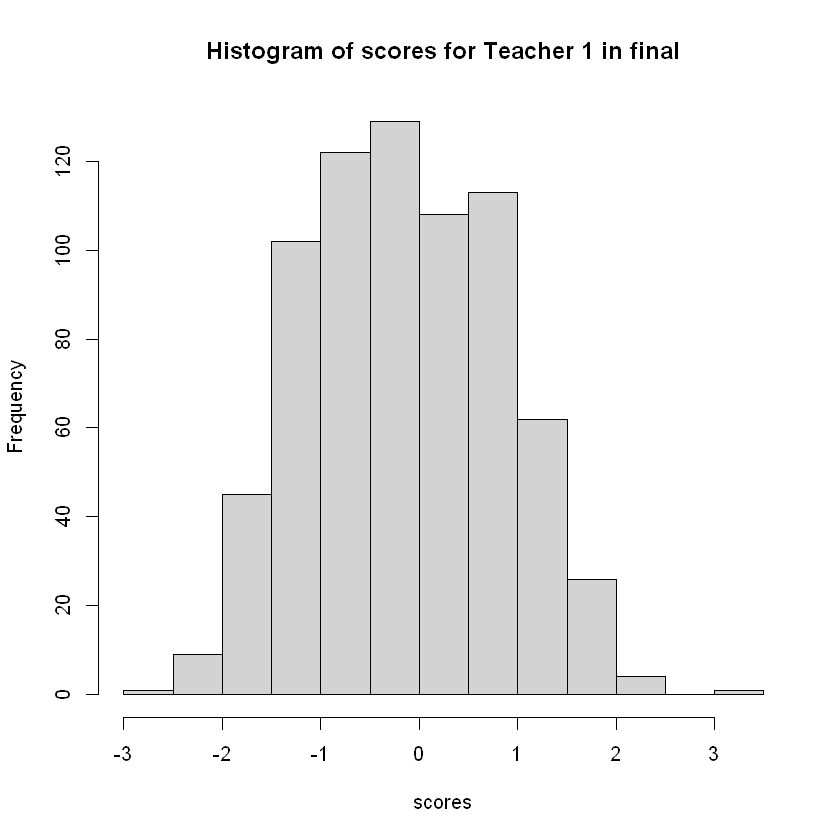

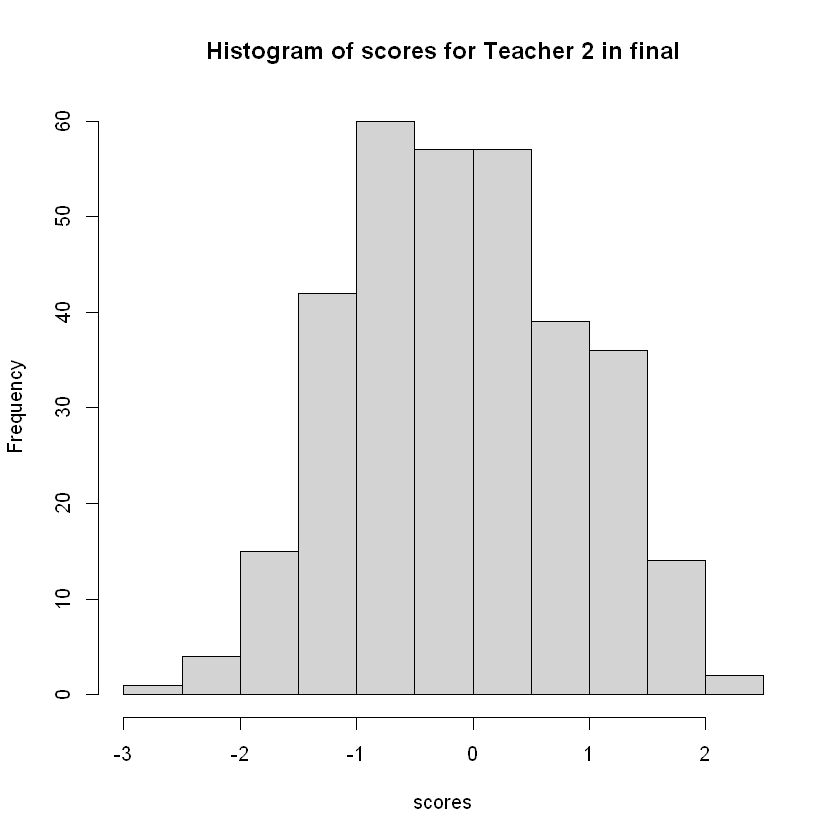

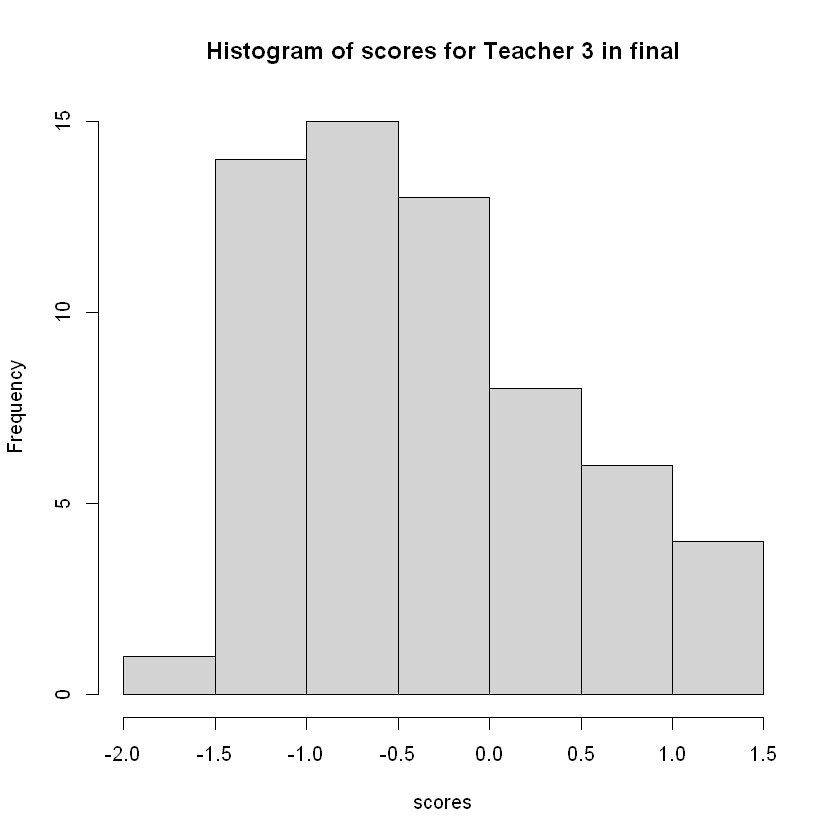

In [8]:
for (i in 1:4){ 
    index = df_trimmed$Teacher_M == i
    scores = df_trimmed$Midterm_std[index]
    hist(scores, main = paste("Histogram of scores for Teacher", i, "in midterm"))
    }

for (i in 1:3){ 
    index = df_trimmed$Teacher_F == i
    scores = df_trimmed$Final_std[index]
    hist(scores, main = paste("Histogram of scores for Teacher", i, "in final"))
    }

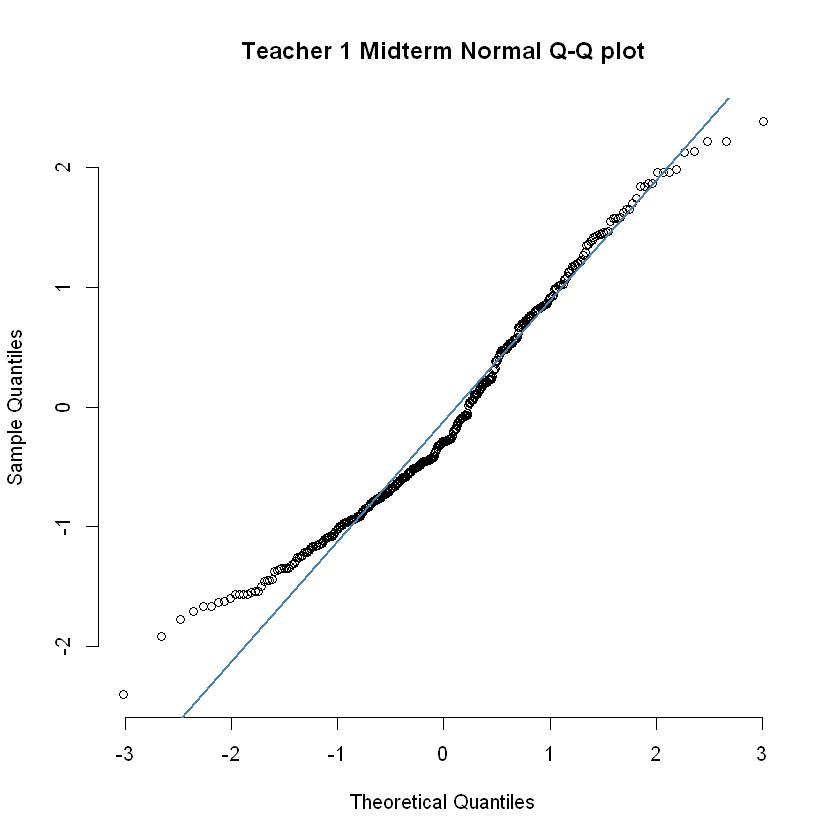

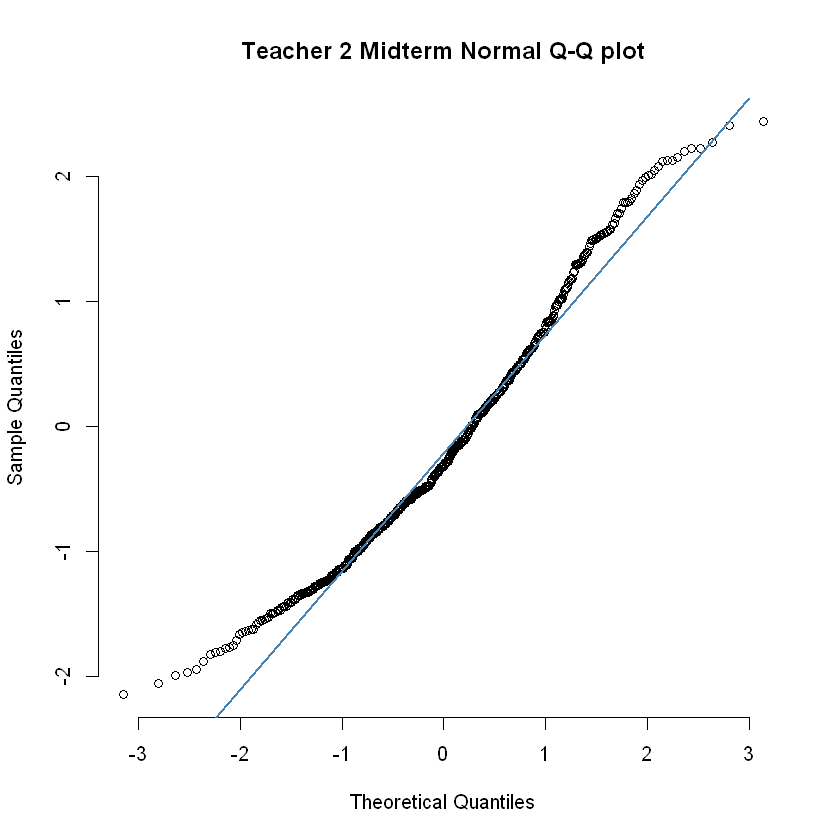

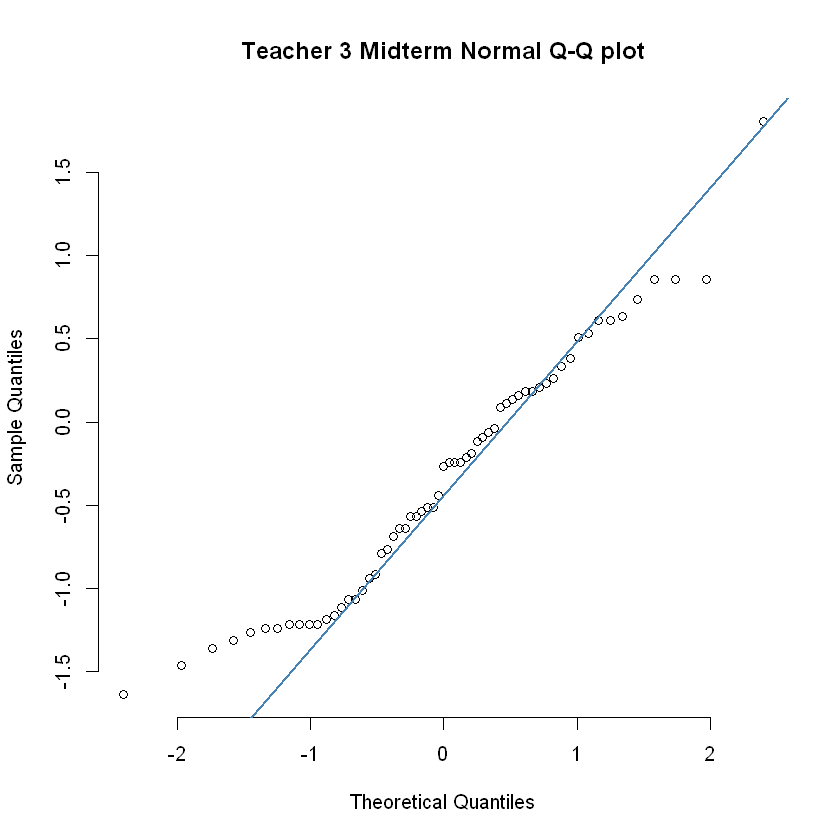

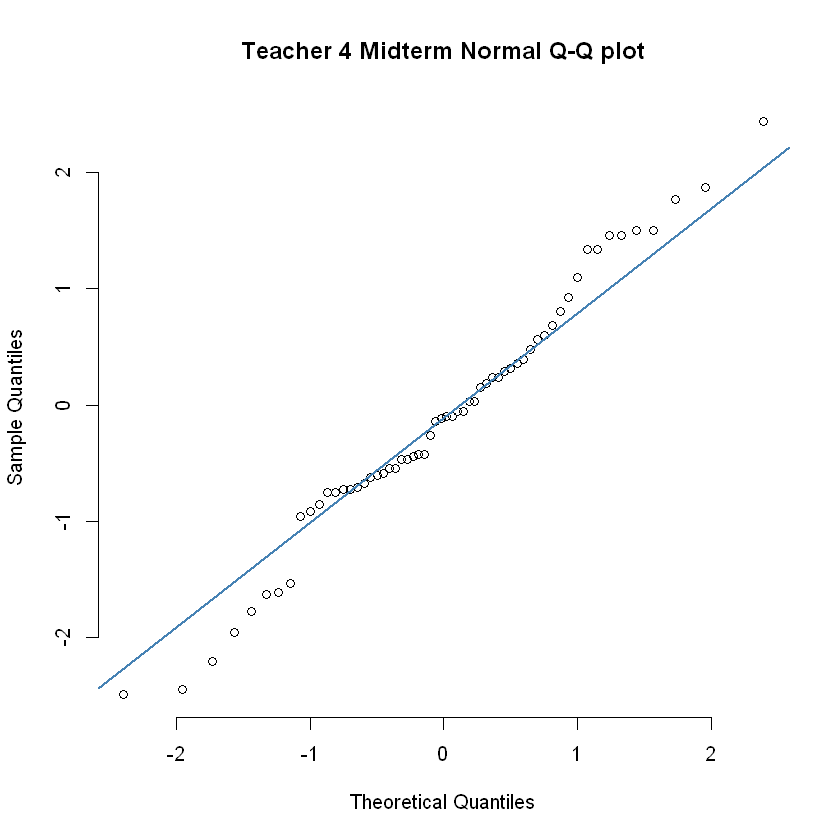

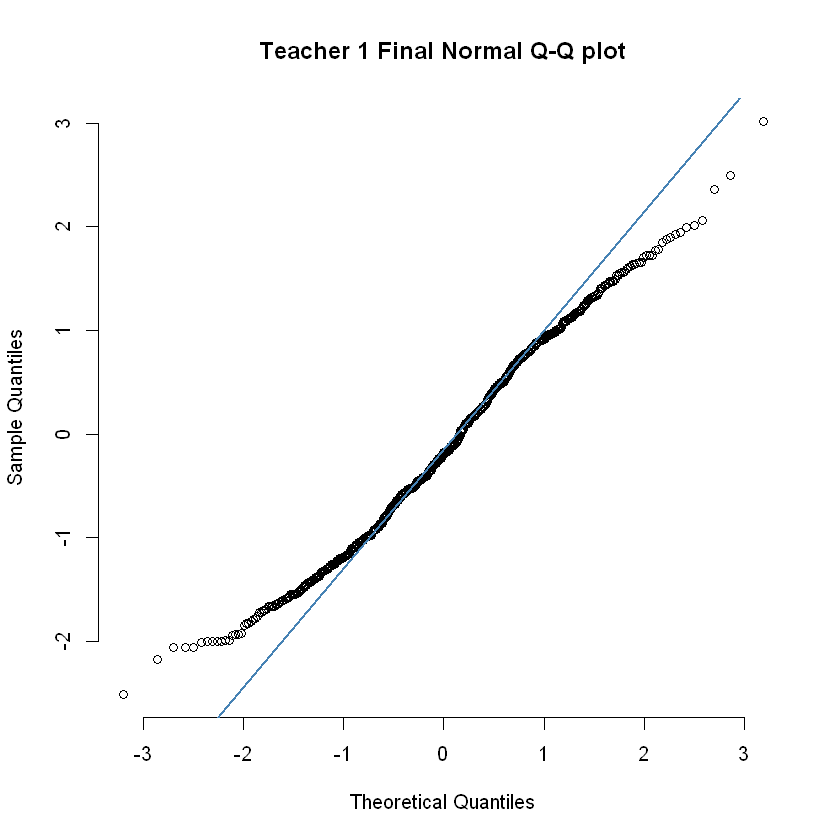

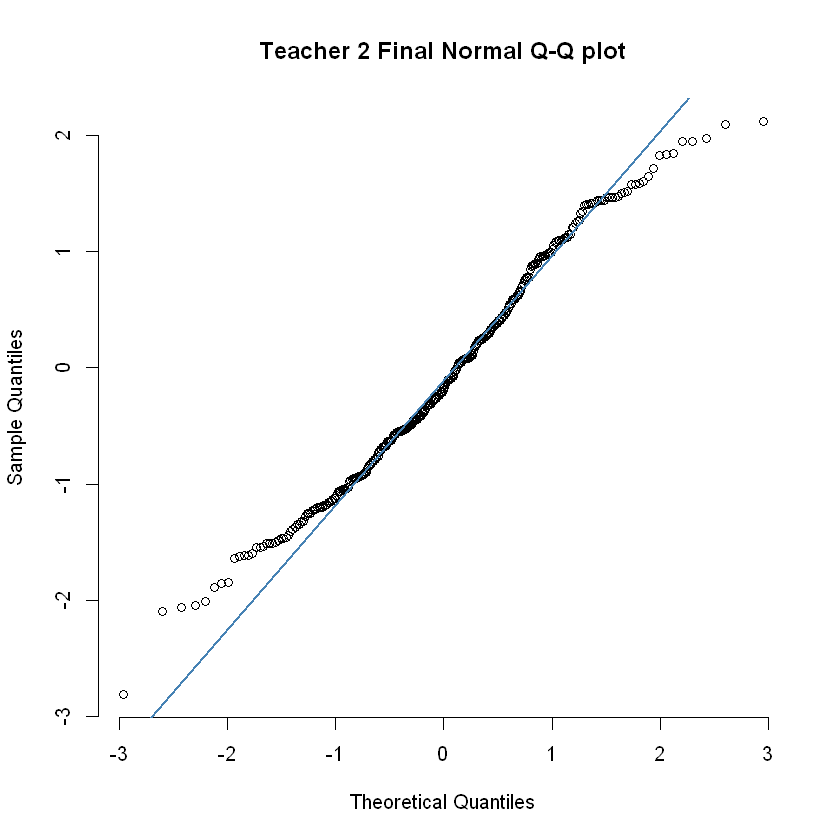

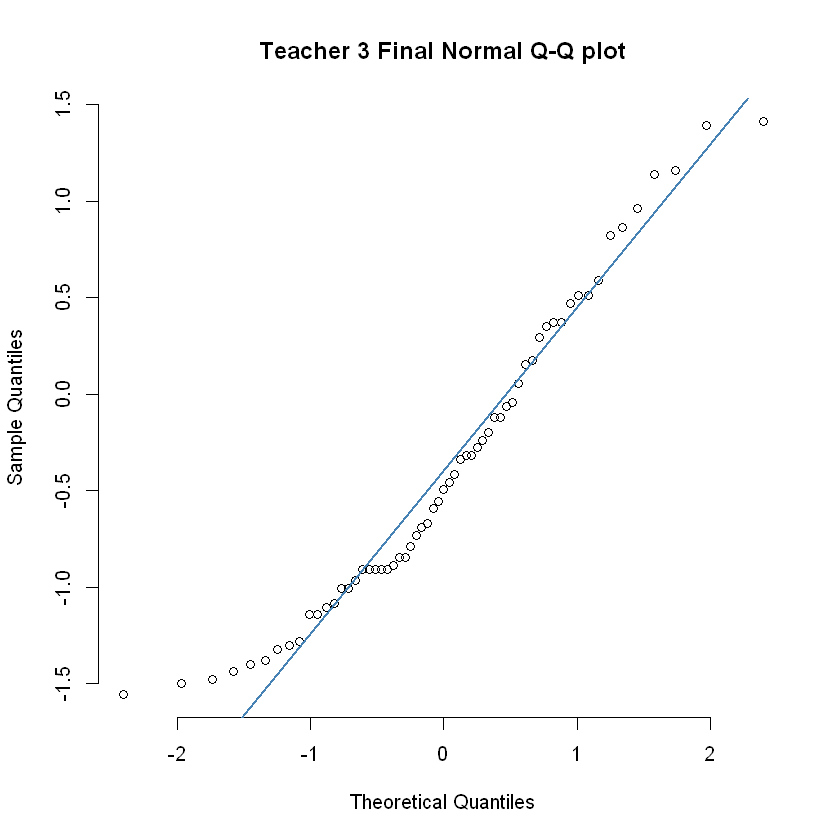

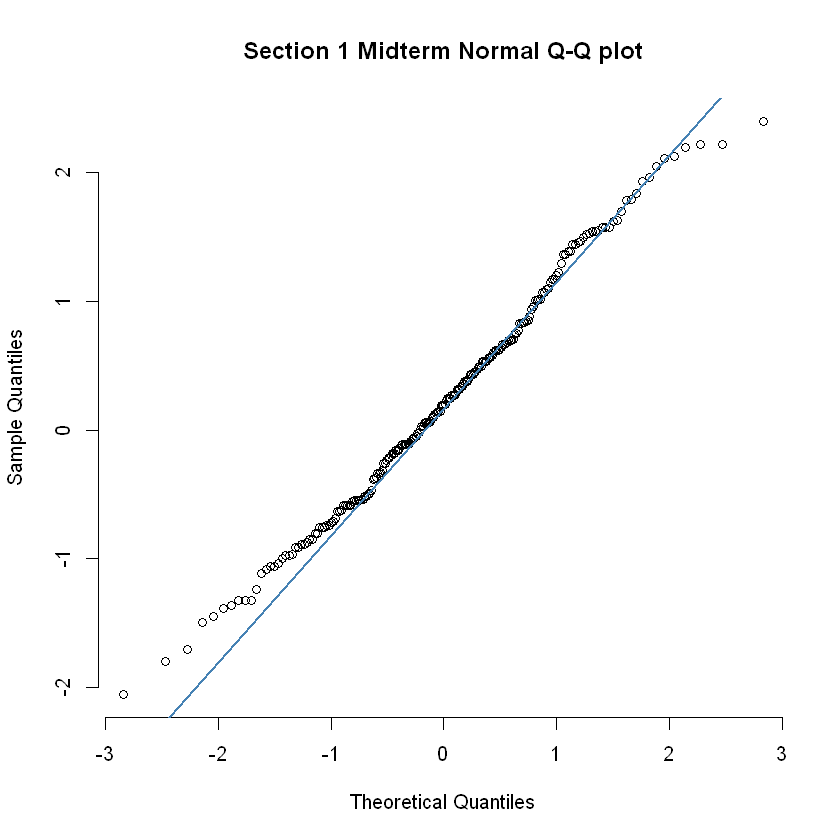

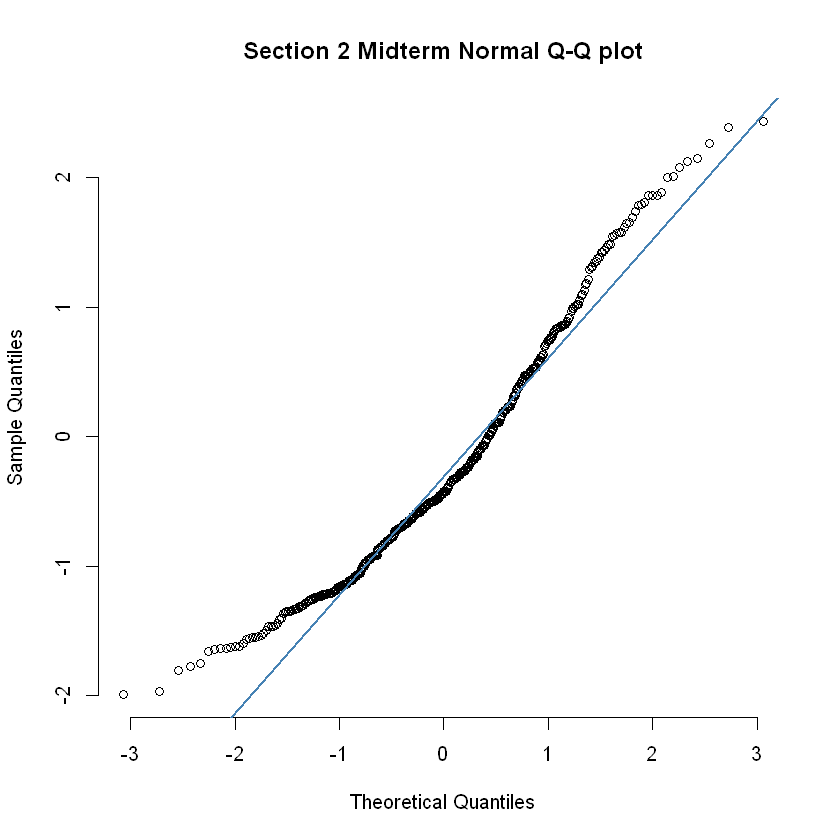

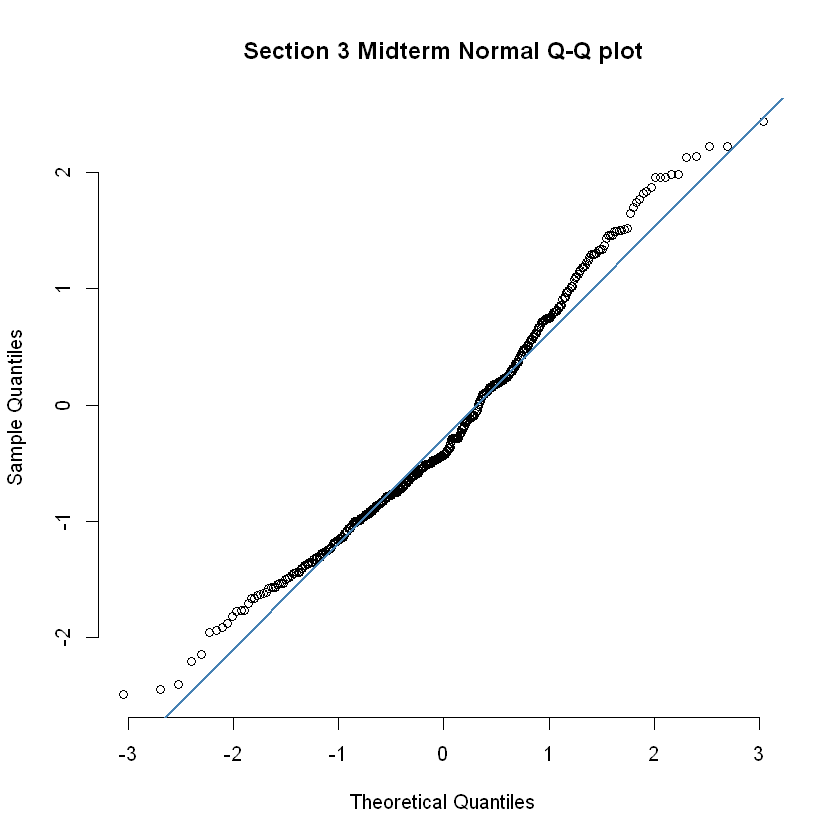

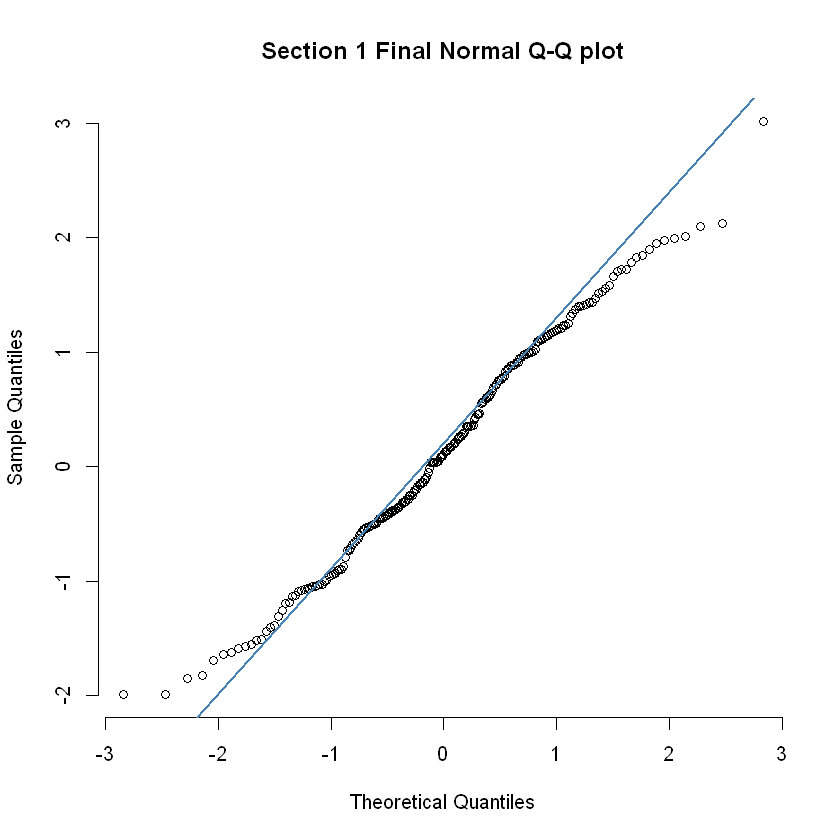

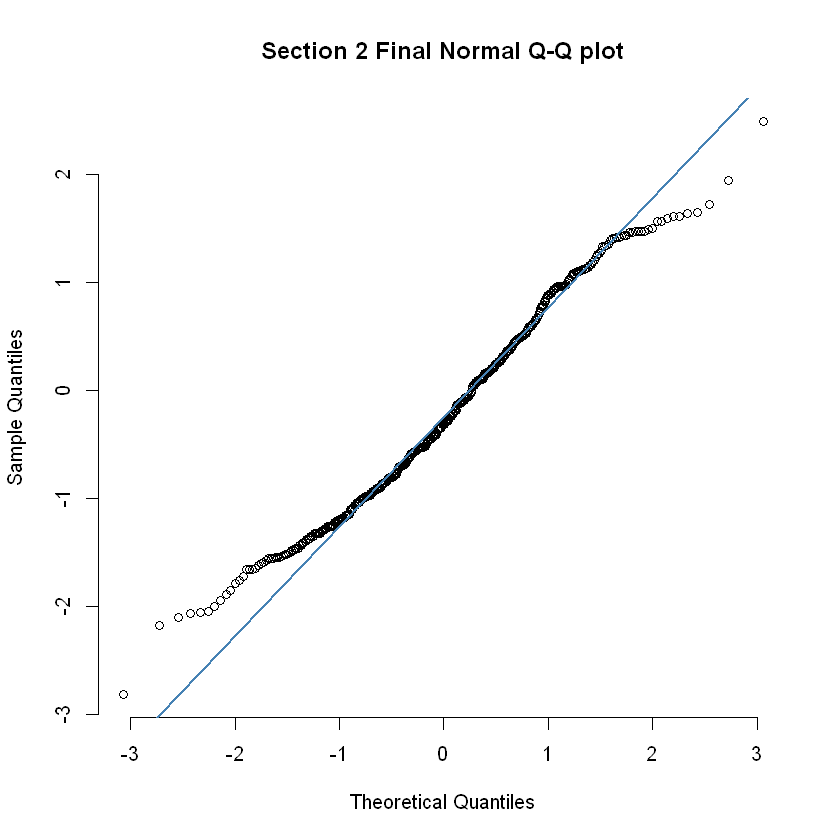

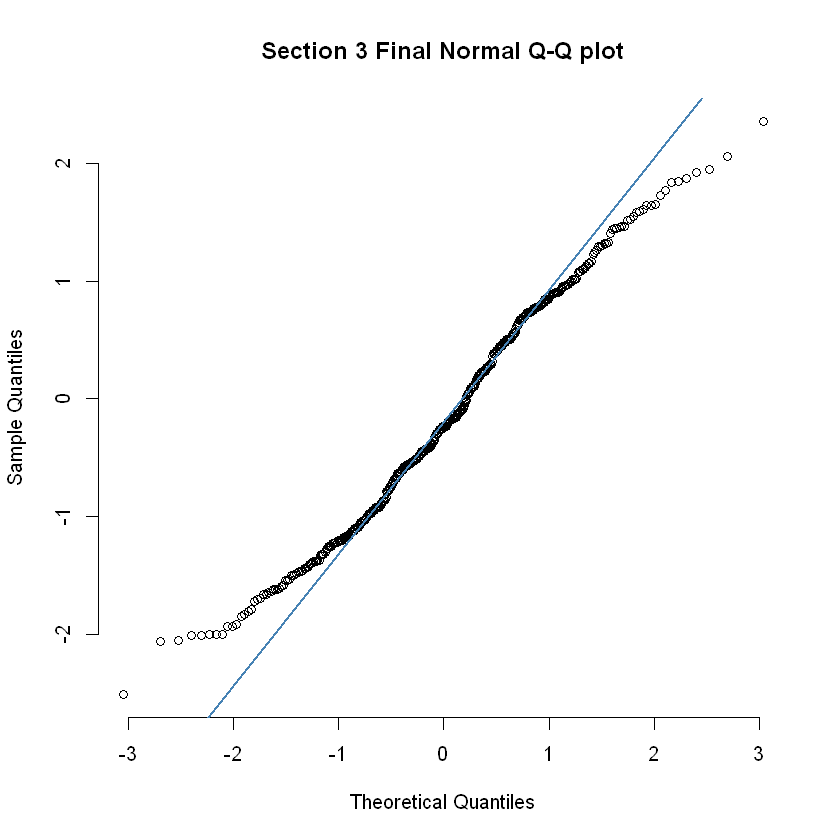

In [9]:
for (i in 1:4){ 
    index = df_trimmed$Teacher_M == i
    scores = df_trimmed$Midterm_std[index]
    text <- paste("Teacher", i, "Midterm", "Normal Q-Q plot")
    qqnorm(scores, main = text, pch = 1, frame = FALSE)
    qqline(scores, col = "steelblue", lwd = 2)
    }

for (i in 1:3){ 
    index = df_trimmed$Teacher_F == i
    scores = df_trimmed$Final_std[index]
    text <- paste("Teacher", i, "Final", "Normal Q-Q plot")
    qqnorm(scores, main = text, pch = 1, frame = FALSE)
    qqline(scores, col = "steelblue", lwd = 2)
    }

for (i in 1:3){ 
    index = df_trimmed$Section == i
    scores = df_trimmed$Midterm_std[index]
    text <- paste("Section", i, "Midterm", "Normal Q-Q plot")
    qqnorm(scores, main = text, pch = 1, frame = FALSE)
    qqline(scores, col = "steelblue", lwd = 2)
    }

for (i in 1:3){ 
    index = df_trimmed$Section == i
    scores = df_trimmed$Final_std[index]
    text <- paste("Section", i, "Final", "Normal Q-Q plot")
    qqnorm(scores, main = text, pch = 1, frame = FALSE)
    qqline(scores, col = "steelblue", lwd = 2)
    }

In [10]:
for (i in 1:4){ 
    index <- df_trimmed$Teacher_M == i
    scores <- df_trimmed$Midterm_std[index]
    print(paste("Teacher", i, "Midterm  p =", shapiro.test(scores))[2])
    }

for (i in 1:3){ 
    index <- df_trimmed$Teacher_F == i
    scores <- df_trimmed$Final_std[index]
    print(paste("Teacher", i, "Midterm  p =", shapiro.test(scores))[2])
    }

for (i in 1:3){ 
    index <- df_trimmed$Section == i
    scores <- df_trimmed$Midterm_std[index]
    print(paste("Section", i, "Midterm  p =", shapiro.test(scores))[2])
    }

for (i in 1:3){ 
    index <- df_trimmed$Section == i
    scores <- df_trimmed$Final_std[index]
    print(paste("Section", i, "Final  p =", shapiro.test(scores))[2])
    }

[1] "Teacher 1 Midterm  p = 1.15167265338288e-06"
[1] "Teacher 2 Midterm  p = 5.36338199379194e-09"
[1] "Teacher 3 Midterm  p = 0.0555769531850325"
[1] "Teacher 4 Midterm  p = 0.489187171323628"
[1] "Teacher 1 Midterm  p = 1.48886037311939e-05"
[1] "Teacher 2 Midterm  p = 0.00211409844754116"
[1] "Teacher 3 Midterm  p = 0.0135997098392331"
[1] "Section 1 Midterm  p = 0.246392605781721"
[1] "Section 2 Midterm  p = 4.30641358960506e-10"
[1] "Section 3 Midterm  p = 1.8728187186455e-05"
[1] "Section 1 Final  p = 0.0795015293422712"
[1] "Section 2 Final  p = 9.64701783957719e-05"
[1] "Section 3 Final  p = 0.000391865376406047"


The Q-Q plots reveal thin tails and some skew. Shapiro-Wilk tests indicate departures from normality almost everywhere, though this is unsurprising due to the generally fairly large sample sizes.  

## 6. Box plots of standardized scores <a id='box'></a>

We can compare the mean standardized scores for each teacher in each exam. 

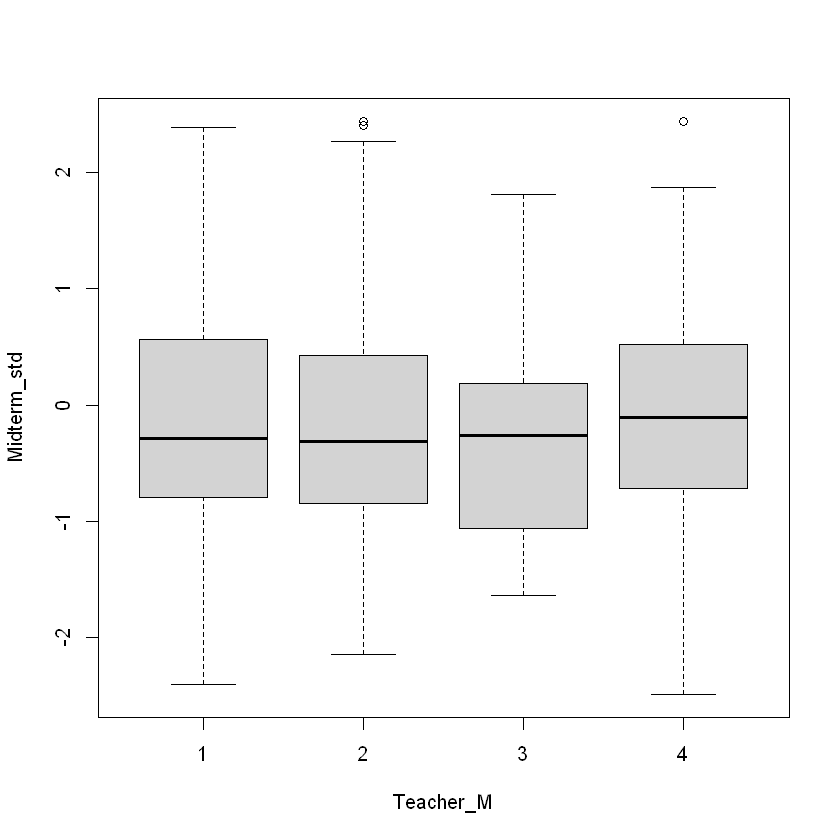

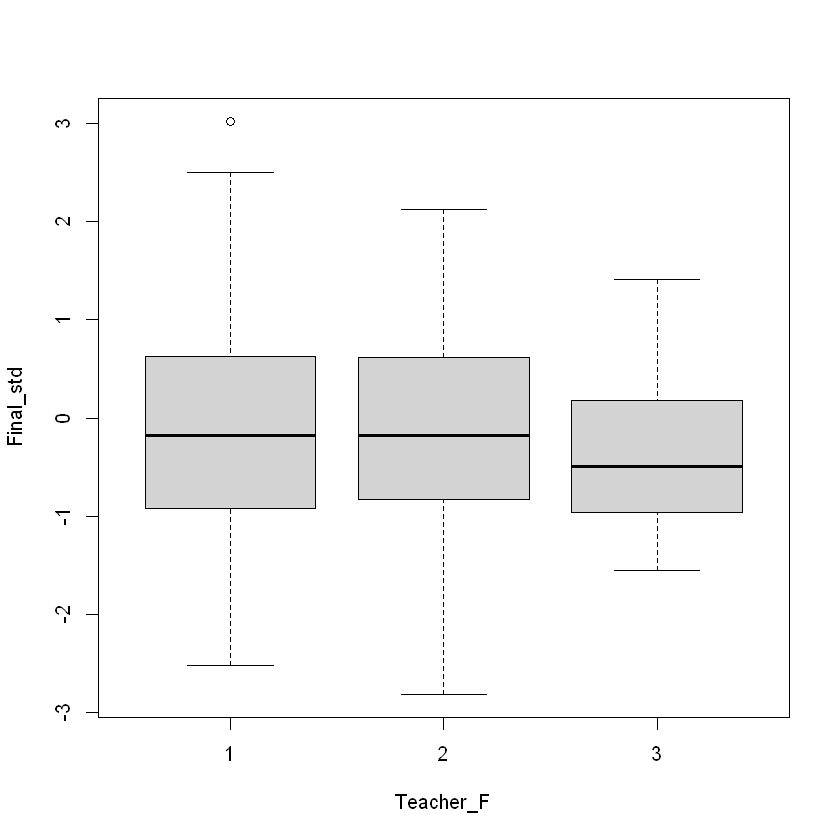

In [11]:
boxplot(Midterm_std ~ Teacher_M,
  data = df_trimmed
)

boxplot(Final_std ~ Teacher_F,
  data = df_trimmed
)

Now we do similar for each section.

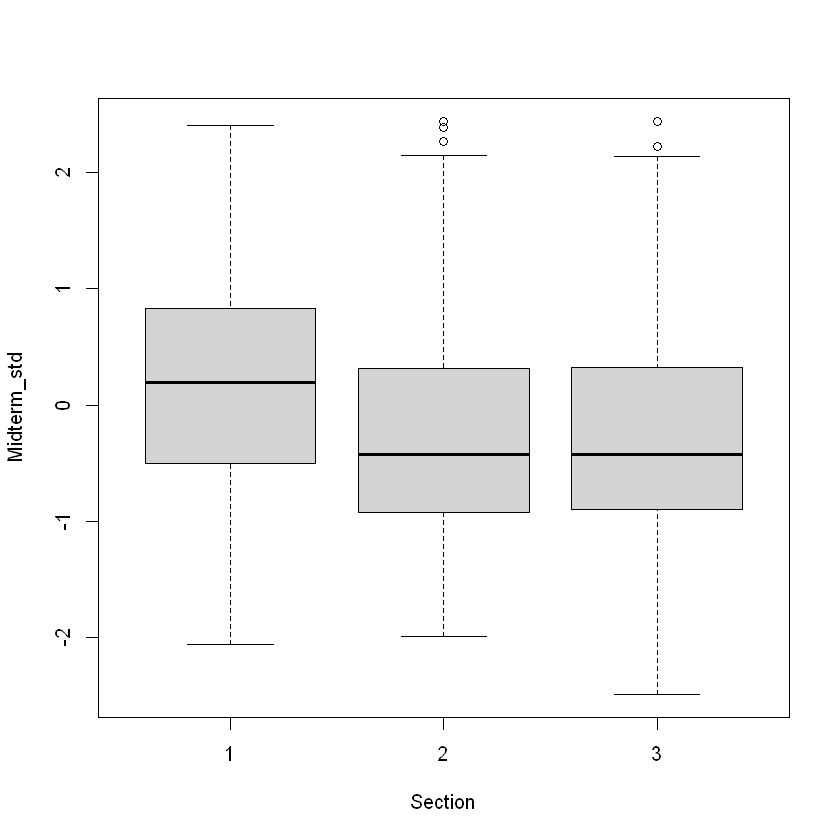

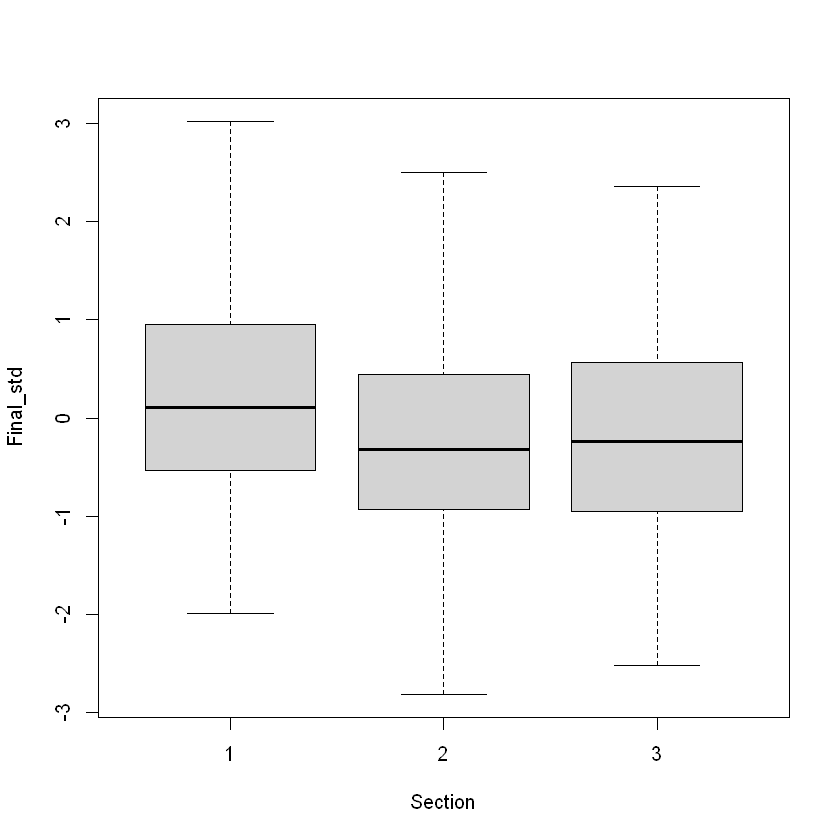

In [12]:
boxplot(Midterm_std ~ Section,
  data = df_trimmed
)

boxplot(Final_std ~ Section,
  data = df_trimmed
)

There is a clear difference between section 1 students and the rest here. Remember that we are excluding the section 1 students from the years with academic selection, so it academic selection does not account for this.

## 7. Classical investigation of teacher influence <a id='teach'></a>
### ANOVA on teacher influence
We can check if ANOVA detects any significant difference in outcomes for students taught by different teachers. Note that for this analysis we have dropped students from section 1 in years 1-4, as they were academically selected. 

We will do a separate analysis for each exam. This could be problematic if one test were to pick up a significant effect, because while the test corrects for multiple comparisons *within* a test, it does not correct *across* tests. Another issue is that these populations are the same students assessed at different times, so are obviously not independent, which would make accounting for the comparisons more difficult. Fortunately for us however, no significant difference is detected in either test, as we see below.

                    Df Sum Sq Mean Sq F value Pr(>F)
factor(Teacher_M)    3    3.2  1.0702   1.221  0.301
Residuals         1106  969.8  0.8768               

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Midterm_std ~ factor(Teacher_M), data = df_trimmed)

$`factor(Teacher_M)`
            diff        lwr        upr     p adj
2-1 -0.057880081 -0.2150038 0.09924367 0.7789854
3-1 -0.236364268 -0.5683846 0.09565606 0.2589497
4-1 -0.004778702 -0.3391789 0.32962151 0.9999821
3-2 -0.178484187 -0.5021672 0.14519887 0.4878125
4-2  0.053101379 -0.2730224 0.37922516 0.9752484
4-3  0.231585566 -0.2064856 0.66965673 0.5247332


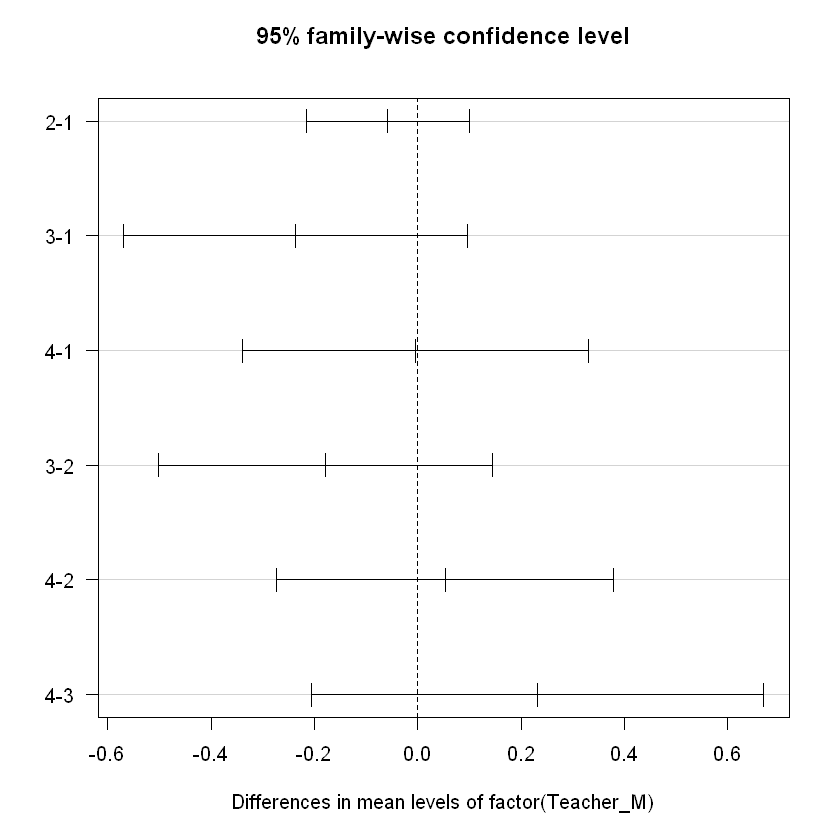

In [13]:
aov_results <- aov(Midterm_std ~ factor(Teacher_M), # need 'factor' here to tell aov that Teacher_M is categorical
  data = df_trimmed
)

summary(aov_results)

TukeyHSD(aov_results, conf.level=.95)

plot(TukeyHSD(aov_results, conf.level=.95), las = 1)

                    Df Sum Sq Mean Sq F value Pr(>F)  
factor(Teacher_F)    2    4.4  2.2222    2.43 0.0885 .
Residuals         1107 1012.2  0.9144                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Final_std ~ factor(Teacher_F), data = df_trimmed)

$`factor(Teacher_F)`
           diff         lwr        upr     p adj
2-1  0.05292503 -0.09666239 0.20251246 0.6842457
3-1 -0.24071565 -0.53994017 0.05850888 0.1426113
3-2 -0.29364068 -0.60662810 0.01934675 0.0712994


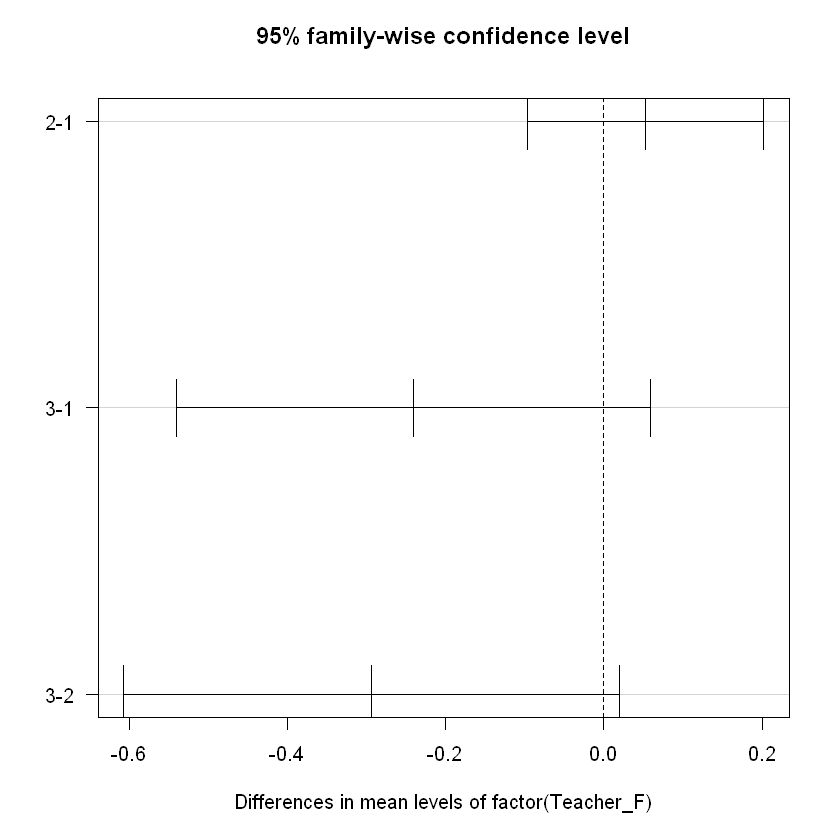

In [14]:
aov_results <- aov(Final_std ~ factor(Teacher_F),
  data = df_trimmed
)

summary(aov_results)

TukeyHSD(aov_results, conf.level=.95)

plot(TukeyHSD(aov_results, conf.level=.95), las = 1)

### Some t-tests
We can also perform basic t-tests comparing students taught by teacher 1 to those taught by teacher 2 directly, as these teachers did the bulk of the teaching. Again we have a potential multiple comparisons issue if one test detects a significant effect and the other does not, but in this case that does not arise as neither test detects any significant difference (as conventionally understood).

In [15]:
index <- df_trimmed$Teacher_M == 1
scores_t1_m <- df_trimmed$Midterm_std[index]

index <- df_trimmed$Teacher_M == 2
scores_t2_m <- df_trimmed$Midterm_std[index]

index <- df_trimmed$Teacher_F == 1
scores_t1_f <- df_trimmed$Final_std[index]

index <- df_trimmed$Teacher_F == 2
scores_t2_f <- df_trimmed$Final_std[index]

t.test(x = scores_t1_m, y = scores_t2_m,
       alternative = "two.sided", paired = FALSE, var.equal = FALSE,
       conf.level = 0.95)

t.test(x = scores_t1_f, y = scores_t2_f,
       alternative = "two.sided", paired = FALSE, var.equal = FALSE,
       conf.level = 0.95)


	Welch Two Sample t-test

data:  scores_t1_m and scores_t2_m
t = 0.9477, df = 820.31, p-value = 0.3436
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06200029  0.17776045
sample estimates:
 mean of x  mean of y 
-0.1064873 -0.1643674 



	Welch Two Sample t-test

data:  scores_t1_f and scores_t2_f
t = -0.82193, df = 627.69, p-value = 0.4114
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.17937289  0.07352283
sample estimates:
  mean of x   mean of y 
-0.13710351 -0.08417848 


Power analysis indicates our tests would have a high chance of detecting an effect of size 0.3 or greater (Cohen's d), and a pretty good chance of detecting an effect of size 0.2. So our data gives us some reason to believe that any difference between the effectiveness of the two teachers should be quite small, if it exists at all. 

In [16]:
effect_sizes = c(0.1,0.2,0.3)
powers = rep(NA, length(effect_sizes))
k = 1
for (d in effect_sizes){   
    h_object <-  pwr.t2n.test(n1 = length(scores_t1_e1), 
                     n2 = length(scores_t2_e1), 
                     d = d, 
                     sig.level = 0.05, 
                     power = NULL,
                     alternative = "greater")
    powers[k] <- paste("when d =", d, " power =", h_object[5], sep = " ") 
    k = k + 1
}

powers

[1] "when d = 0.1  power = 0.482201005639022"
[2] "when d = 0.2  power = 0.940097467967087"
[3] "when d = 0.3  power = 0.999199746054519"

## 8. The influence of section numbering - Classical analysis <a id='sec'></a>
Here we repeat some of the classical analysis on the effect of section numbering on our new data. Note that since these are largely the same students transposed by a year, this data is not independent of the data from the previous notebook.
### t-tests for section number using sections 2 and 3

In [17]:
index <- df_trimmed$Section == 2
scores_M2 <- df_trimmed$Midterm_std[index]

index <- df_trimmed$Section == 3
scores_M3 <- df_trimmed$Midterm_std[index]

index <- df_trimmed$Section == 2
scores_F2 <- df_trimmed$Final_std[index]

index <- df_trimmed$Section == 3
scores_F3 <- df_trimmed$Final_std[index]

t.test(x = scores_M2, y = scores_M3,
       alternative = "two.sided", paired = FALSE, var.equal = FALSE,
       conf.level = 0.95)

t.test(x = scores_F2, y = scores_F3,
       alternative = "two.sided", paired = FALSE, var.equal = FALSE,
       conf.level = 0.95)


	Welch Two Sample t-test

data:  scores_M2 and scores_M3
t = -0.13033, df = 880.31, p-value = 0.8963
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1293414  0.1132334
sample estimates:
 mean of x  mean of y 
-0.2472692 -0.2392152 



	Welch Two Sample t-test

data:  scores_F2 and scores_F3
t = -0.68027, df = 880.36, p-value = 0.4965
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.16612582  0.08060715
sample estimates:
 mean of x  mean of y 
-0.2234632 -0.1807039 


In [18]:
effect_sizes = c(0.1,0.2,0.3)
powers = rep(NA, length(effect_sizes))
k = 1
for (d in effect_sizes){   
    h_object <-  pwr.t2n.test(n1 = length(scores_M2), 
                     n2 = length(scores_M3), 
                     d = d, 
                     sig.level = 0.05, 
                     power = NULL,
                     alternative = "greater")
    powers[k] <- paste("when d =", d, " power =", h_object[5], sep = " ") 
    k = k + 1
}

powers


[1] "when d = 0.1  power = 0.43930457027749" 
[2] "when d = 0.2  power = 0.909777698684432"
[3] "when d = 0.3  power = 0.997683533879219"

Though the mean for section 3 is lower than the mean for section 2, none of our (not independent) t-tests produce statistical significance. Power analysis indicates that this does not rule out a small effect, but provides strong evidence against $d=0.3$ or higher.

### ANOVA for sections on years 5-8.

                  Df Sum Sq Mean Sq F value   Pr(>F)    
factor(Section)    2   38.8  19.402   22.99 1.65e-10 ***
Residuals       1107  934.2   0.844                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Midterm_std ~ factor(Section), data = df_trimmed)

$`factor(Section)`
          diff        lwr        upr     p adj
2-1 -0.4752631 -0.6526895 -0.2978366 0.0000000
3-1 -0.4672091 -0.6466632 -0.2877550 0.0000000
3-2  0.0080540 -0.1363238  0.1524318 0.9905954


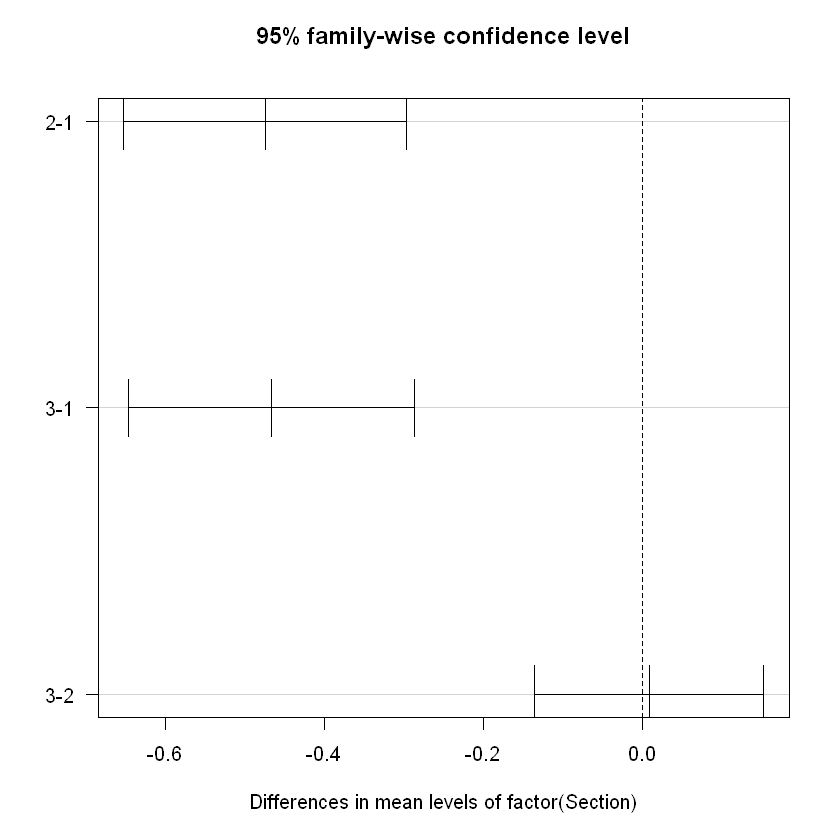

In [19]:
aov_results <- aov(Midterm_std ~ factor(Section),
  data = df_trimmed
)

summary(aov_results)

TukeyHSD(aov_results, conf.level=.95)

plot(TukeyHSD(aov_results, conf.level=.95), las = 1)

                  Df Sum Sq Mean Sq F value   Pr(>F)    
factor(Section)    2   21.6  10.791   12.01 6.95e-06 ***
Residuals       1107  995.1   0.899                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Final_std ~ factor(Section), data = df_trimmed)

$`factor(Section)`
           diff        lwr        upr     p adj
2-1 -0.36890716 -0.5520229 -0.1857914 0.0000076
3-1 -0.32614782 -0.5113562 -0.1409394 0.0001141
3-2  0.04275934 -0.1062481  0.1917667 0.7789891


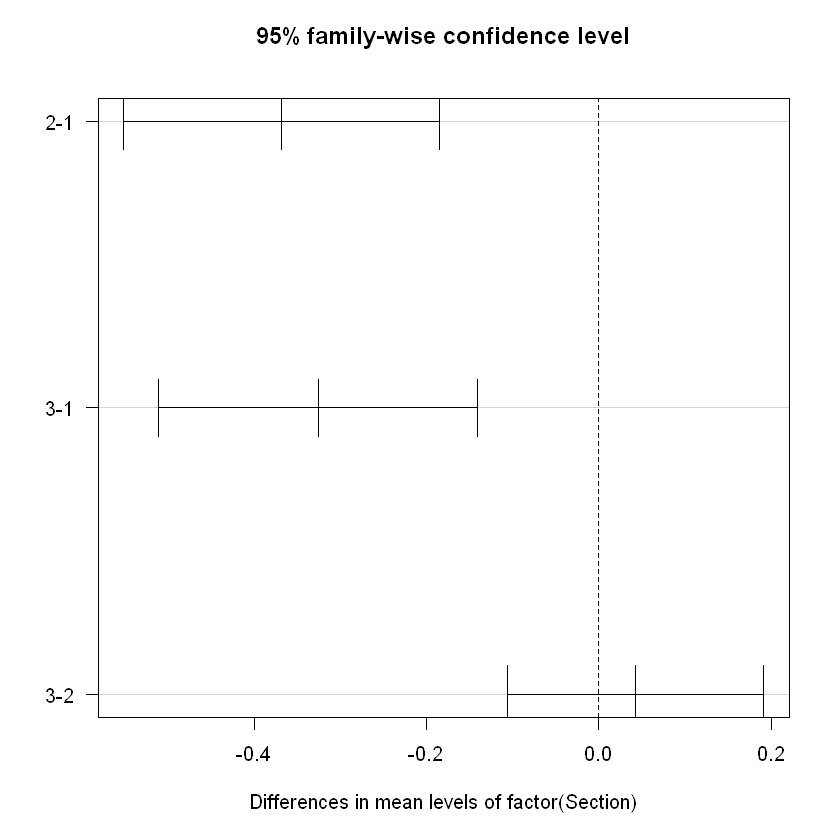

In [20]:
aov_results <- aov(Final_std ~ factor(Section),
  data = df_trimmed
)

summary(aov_results)

TukeyHSD(aov_results, conf.level=.95)

plot(TukeyHSD(aov_results, conf.level=.95), las = 1)

The results of ANOVA on the years without academic selection are interesting. Here we see an apparently significant effect for section 1 relative to the others. This is not what we saw in the previous notebook, though their is significant overlap between the two sets of students involved. Clearly the unusually high performance of section 1 relative to section 2 in year 5, despite the lack of academic selection, is involved here. We will return to this point during the course of a Bayesian analysis, conducted below. 

## 9. Three Bayesian models <a id='bayes'></a>
A Bayesian approach allows us to deal with all years, teachers and exams simultaneously.
### The first model
This is similar to the model comparing sections for the 2nd year exam from the other notebook. The only difference is we now have two exams, which we initially treat as independent for simplicity, and we also add indicator variables and associated coefficients for each teacher. One assumption here is that teacher influence is the same across exams. We will remove this assumption in the next model for comparison.

$i\in\{1,\ldots,N\}$ ($N$ is number of students) and $k\in\{M,F\}$ (exams)

#### Model

$E_k \sim Normal(\mu_k, \sigma_k)$ ...   ($E_k$ is score in exam $k\in\{M,F\}$).

$\mu_k = \alpha_k  + \sum^4_{i=1}\beta_{T_i}T_{i,k} + \beta_A\sum_{i=1}^{N_A-1} \delta_i^A + \beta_S \sum_{j=i}^{N_S-1} \delta_j^B$

Here $N_A$ is the academic streaming value, and $N_S$ is the section value, and we have $\sum_{i=1}^{2} \delta_i^A = \sum_{j=i}^{2} \delta_j^B = 1$. So the parameters $\beta_A$ and $\beta_S$ control the maximum possible effect of academic selection and section, respectively, while the individual $\delta$ values break this contribution down into pieces. E.g. A student with academic selection value of 3 gets the full value of $\beta_A$, while one with an academic selection value of 2 gets only $\delta_1^A\beta_A$, which is smaller, and a student with an academic selection value of 1 gets no contribution at all.

$T_{i,k}$ is indicator variable for whether student was or was not taught by teacher $i$ for exam $k$. 

#### Priors

$\sigma_k \sim LogNorm(0,0.25)$

$(\delta^A_1, \delta^A_2), (\delta^S_1, \delta^S_2) \sim Dirichlet(2,2)$

$a_k, \beta_{T_i}, \beta_A, \beta_S \sim Norm(0,1)$

In [21]:
df_full <- df

df_full$M_t1 <- ifelse(df_full$Teacher_M == 1, 1., 0.)
df_full$M_t2 <- ifelse(df_full$Teacher_M == 2, 1., 0.)
df_full$M_t3 <- ifelse(df_full$Teacher_M == 3, 1., 0.)
df_full$M_t4 <- ifelse(df_full$Teacher_M == 4, 1., 0.)

df_full$F_t1 <- ifelse(df_full$Teacher_F == 1, 1., 0.)
df_full$F_t2 <- ifelse(df_full$Teacher_F == 2, 1., 0.)
df_full$F_t3 <- ifelse(df_full$Teacher_F == 3, 1., 0.)
df_full$F_t4 <- ifelse(df_full$Teacher_F == 4, 1., 0.)

df_full$Stream_level <- ifelse(df_full$Section == 1 & df_full$Year < 5, 3., ifelse(df_full$Year < 5, 1., 2. ))

str(df_full)

'data.frame':	1359 obs. of  18 variables:
 $ Section     : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm     : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final       : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M   : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std : num  1.932 1.329 -0.399 0.506 0.177 ...
 $ Final_std   : num  1.355 0.957 -0.522 0.957 0.843 ...
 $ M_t1        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t2        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ M_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t1        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ F_t2        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Stream_level: num  3 1 1 1 1 1 1 3 1 1 ...


In [22]:
dat <- list(
  N = 1359,
  M = df_full$Midterm_std, # scores for midterm
  F = df_full$Final_std, # scores for final
  
  # indicator variables for teachers in midterm
  M_t1 = df_full$M_t1, 
  M_t2 = df_full$M_t2,
  M_t3 = df_full$M_t3, 
  M_t4 = df_full$M_t4,  
  
  # indicator variables for teachers in final
  F_t1 = df_full$F_t1, 
  F_t2 = df_full$F_t2,
  F_t3 = df_full$F_t3, 
  F_t4 = df_full$F_t4,
    
  A = df_full$Stream_level, # discrete ordered predictor for 3 levels of streaming
  S = df_full$Section, # section number
  alpha = rep( 2 , 2 ) # parameters for Dirichlet priors
)

In [23]:
code_1 <- 'data{
    int N;
    vector[N] M;
    vector[N] F;
    int M_t1[N];
    int M_t2[N];
    int M_t3[N];
    int M_t4[N];
    int F_t1[N];
    int F_t2[N];
    int F_t3[N];
    int F_t4[N];
    int S[N];
    int A[N];
    vector[2] alpha;
}
parameters{
    real bt1;
    real bt2;
    real bt3;
    real bt4;
    real a_F;
    real a_M;
    real bS;
    real bA;
    real<lower=0> sigma_M;
    real<lower=0> sigma_F;
    simplex[2] deltaA;
    simplex[2] deltaS;
    
}

transformed parameters{
vector[3] deltaA_j;
vector[3] deltaS_j;
deltaS_j = append_row(0, deltaS);
deltaA_j = append_row(0, deltaA);
}

model{
    vector[N] mu_M;
    vector[N] mu_F;
    a_M ~ normal( 0 , 1 );
    a_F ~ normal( 0 , 1 );
    bt1 ~ normal( 0 , 1 );
    bt2 ~ normal( 0 , 1 );
    bt3 ~ normal( 0 , 1 );
    bt4 ~ normal( 0 , 1 );
    sigma_F ~ lognormal( 0, 0.25 );
    sigma_M ~ lognormal( 0,  0.25 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    for ( i in 1:N ) {
        mu_F[i] = a_F + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu_M[i] = a_M + bt1*M_t1[i] + bt2*M_t2[i] + bt3*M_t3[i] + bt4*M_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
    }
    F ~ normal( mu_F , sigma_F );
    M ~ normal( mu_M , sigma_M );
}
generated quantities{
vector[N] log_lik;

for (i in 1:N) log_lik[i] = normal_lpdf(F[i] | a_F + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]), 
                                    sigma_F)

                             + normal_lpdf(M[i] | a_M + bt1*M_t1[i] + bt2*M_t2[i] + bt3*M_t3[i] + bt4*M_t4[i] 
                                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]), 
                                    sigma_M);
                              
}'

In [24]:
model_1 <- stan( model_code = code_1 , data = dat , chains=4, 
                 cores = 4, iter = num_iters )

In [25]:
results_1 <- summary(model_1, probs = c(0.05, 0.95), 
                     pars = c('sigma_M', 'sigma_F', 'bt1', 'bt2', 
                              'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_1

,mean,se_mean,sd,5%,95%,n_eff,Rhat
sigma_M,0.928900972,0.0001818485,0.01766356,0.90001802,0.9586110,9434.892,1.000056
sigma_F,0.946444205,0.0001947371,0.01813428,0.91746384,0.9766704,8671.672,1.000256
bt1,0.005960483,0.0078517415,0.41162791,-0.66765827,0.6899771,2748.386,1.000556
bt2,-0.010742350,0.0078346630,0.41133495,-0.68873990,0.6750451,2756.453,1.000550
bt3,-0.078645315,0.0079341078,0.41811110,-0.75720075,0.6198190,2777.072,1.000686
bt4,0.006908557,0.0078756295,0.42561548,-0.69058101,0.7102048,2920.548,1.000339
a_M,-0.017498138,0.0078985360,0.41257486,-0.70693685,0.6601582,2728.427,1.000947
a_F,-0.022264338,0.0078886328,0.41238467,-0.70620905,0.6554419,2732.760,1.000974
bS,-0.303885415,0.0007879526,0.06214948,-0.40522212,-0.2013339,6221.208,1.001163
bA,0.661401985,0.0010202450,0.08084062,0.52821290,0.7946661,6278.419,1.000738


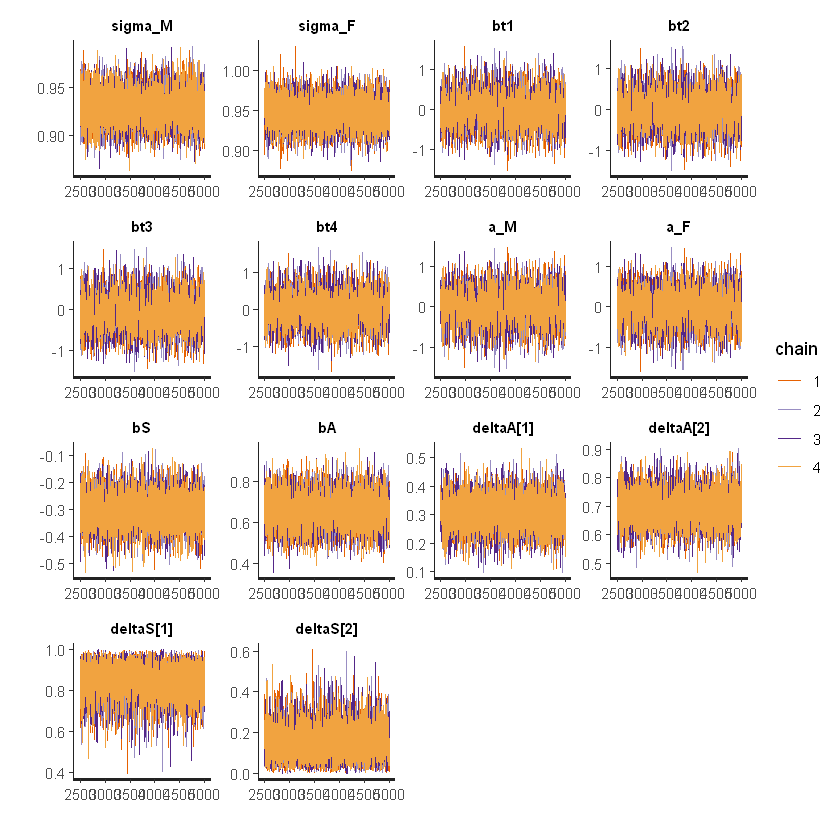

In [26]:
pars = c('sigma_M', 'sigma_F', 'bt1', 'bt2', 
                              'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS')

stan_trace(model_1, pars = pars)

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.
ℹ The deprecated feature was likely used in the rstan package.
  Please report the issue at <https://github.com/stan-dev/rstan/issues/>."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


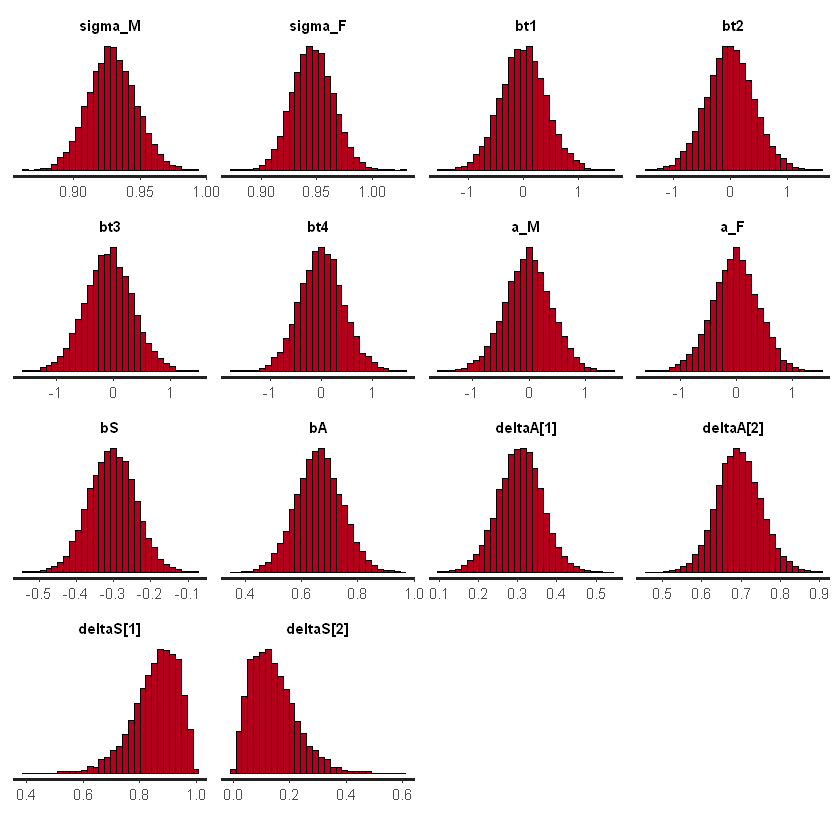

In [27]:
stan_hist(model_1, pars = pars)

In [28]:
samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.2, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.2:", p, sep = " ")

samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.1, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.1:", p, sep = " ")

samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.05, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.05:", p, sep = " ")

[1] "Proportion less than -0.2: 0.9524"

[1] "Proportion less than -0.1: 0.9994"

[1] "Proportion less than -0.05: 1"

### The second model
In this model we modify the previous one to allow teachers to have different influences in different exams. So in place of the coefficients $\beta_{T_i}$ we know have coefficients $\beta_{T_{i,k}}$ for each $i\in\{1,2,3,4\}$ and $k\in\{M,F\}$. These have the same Normal priors as the $\beta_{T_i}$.

As we will see this doesn't make much difference.

In [29]:
code_2 <- 'data{
    int N;
    vector[N] M;
    vector[N] F;
    int M_t1[N];
    int M_t2[N];
    int M_t3[N];
    int M_t4[N];
    int F_t1[N];
    int F_t2[N];
    int F_t3[N];
    int F_t4[N];
    int S[N];
    int A[N];
    vector[2] alpha;
}
parameters{
    real bM_t1;
    real bM_t2;
    real bM_t3;
    real bM_t4;
    real bF_t1;
    real bF_t2;
    real bF_t3;
    real bF_t4;
    real a_F;
    real a_M;
    real bS;
    real bA;
    real<lower=0> sigma_M;
    real<lower=0> sigma_F;
    simplex[2] deltaA;
    simplex[2] deltaS;
    
}

transformed parameters{
vector[3] deltaA_j;
vector[3] deltaS_j;
deltaS_j = append_row(0, deltaS);
deltaA_j = append_row(0, deltaA);
}

model{
    vector[N] mu_M;
    vector[N] mu_F;
    a_M ~ normal( 0 , 1 );
    a_F ~ normal( 0 , 1 );
    bM_t1 ~ normal( 0 , 1 );
    bF_t1 ~ normal( 0 , 1 );
    bM_t2 ~ normal( 0 , 1 );
    bF_t2 ~ normal( 0 , 1 );
    bM_t3 ~ normal( 0 , 1 );
    bF_t3 ~ normal( 0 , 1 );
    bM_t4 ~ normal( 0 , 1 );
    bF_t4 ~ normal( 0 , 1 );
    sigma_F ~ lognormal( 0, 0.25 );
    sigma_M ~ lognormal( 0,  0.25 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    for ( i in 1:N ) {
        mu_F[i] = a_F + bF_t1*F_t1[i] + bF_t2*F_t2[i] + bF_t3*F_t3[i] + bF_t4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu_M[i] = a_M + bM_t1*M_t1[i] + bM_t2*M_t2[i] + bM_t3*M_t3[i] + bM_t4*M_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
    }
    F ~ normal( mu_F , sigma_F );
    M ~ normal( mu_M , sigma_M );
}
generated quantities{
vector[N] log_lik;

for (i in 1:N) log_lik[i] = normal_lpdf(F[i] | a_F + bF_t1*F_t1[i] + bF_t2*F_t2[i] + bF_t3*F_t3[i] + bF_t4*F_t4[i] 
                                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]), 
                                    sigma_F)

                             + normal_lpdf(M[i] | a_M + bM_t1*M_t1[i] + bM_t2*M_t2[i] + bM_t3*M_t3[i] + bM_t4*M_t4[i] 
                                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]), 
                                    sigma_M);
                              
}'

In [30]:
model_2 <- stan( model_code = code_2 , data = dat , chains=4, 
                 cores = 4, iter = num_iters )

In [31]:
results_2 <- summary(model_2, probs = c(0.025, 0.975), 
                     pars = c('sigma_M', 'sigma_F', 'bM_t1', 'bM_t2', 
                              'bM_t3', 'bM_t4', 'bF_t1', 'bF_t2', 'bF_t3', 'bF_t4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_2

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
sigma_M,0.928720954,0.0001526906,0.01744290,0.8953530,0.9635215,13050.068,0.9998776
sigma_F,0.946830870,0.0001609759,0.01792057,0.9128232,0.9828539,12393.153,0.9998358
bM_t1,0.042981941,0.0077690120,0.45926131,-0.8491224,0.9549673,3494.525,1.0006879
bM_t2,-0.029189754,0.0077362297,0.45754119,-0.9169162,0.8772139,3497.854,1.0007132
bM_t3,-0.066590202,0.0077982348,0.46928084,-0.9861478,0.8598089,3621.371,1.0008076
bM_t4,0.014261356,0.0077783667,0.46708791,-0.8985544,0.9284673,3605.956,1.0006662
bF_t1,0.006520974,0.0078520316,0.50516420,-0.9911663,1.0004453,4139.054,1.0003617
bF_t2,0.040171685,0.0078217167,0.50609669,-0.9641382,1.0384796,4186.613,1.0003722
bF_t3,-0.077724447,0.0077320414,0.51306981,-1.0917529,0.9276081,4403.161,1.0002225
bF_t4,0.010489134,0.0094644284,1.00425275,-1.9314277,1.9897455,11258.934,0.9997165


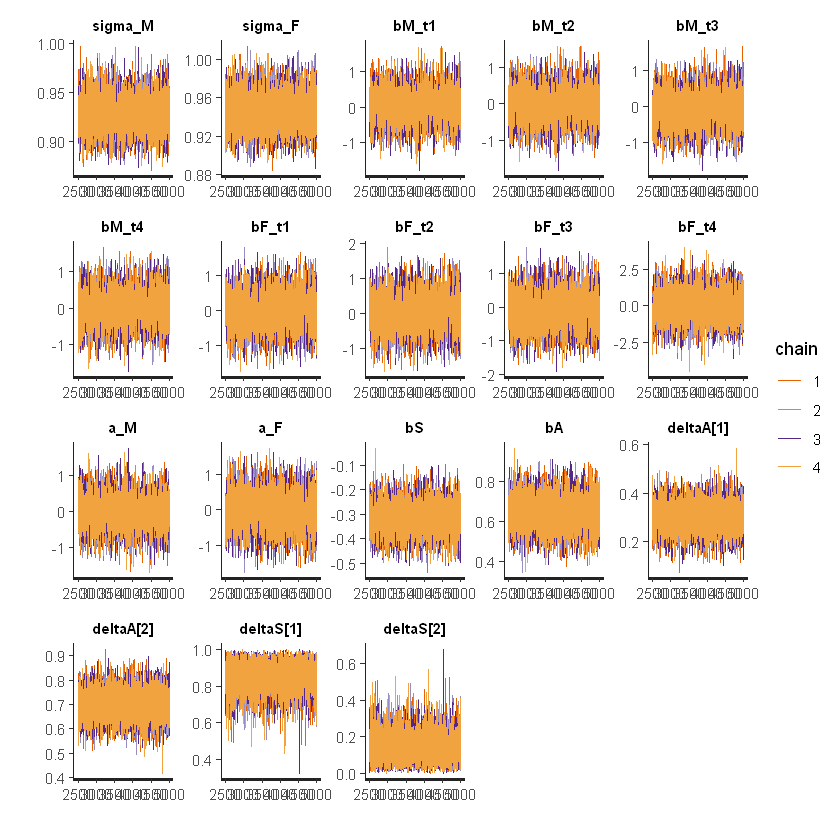

In [32]:
pars = c('sigma_M', 'sigma_F', 'bM_t1', 'bM_t2', 
                              'bM_t3', 'bM_t4', 'bF_t1', 'bF_t2', 'bF_t3', 'bF_t4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS')

stan_trace(model_2, pars = pars)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


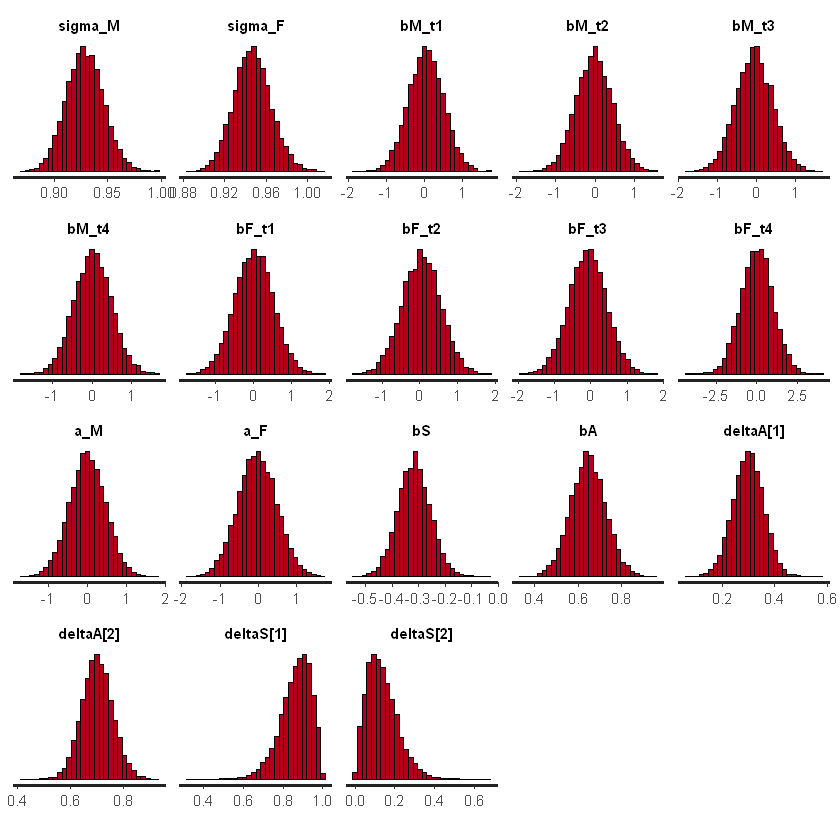

In [33]:
stan_hist(model_2, pars = pars)

In [34]:
samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.2, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.2:", p, sep = " ")

samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.1, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.1:", p, sep = " ")

samples <- extract(model_1, 'bS') 
counts <- ifelse(samples$bS < -0.05, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.05:", p, sep = " ")

[1] "Proportion less than -0.2: 0.9524"

[1] "Proportion less than -0.1: 0.9994"

[1] "Proportion less than -0.05: 1"

### Correlated exam results <a id='model3'></a>
For better realism we can treat exam results from our two exams as being correlated. This corresponds to the fact that unmodeled factors such as student motivation/ability play a role. Apart from this change, our model here is the same as the first one.

$i\in\{1,\ldots,N\}$ ($N$ is number of students) and $k\in\{M,F\}$ (exams)

#### Model

$E \sim MultiNormal(\mu, \Sigma)$ ...   ($E$ is a multivariate normal distribution for two variables. As is typical, the covariance matrix $\Sigma$ will be modeled using a vector of standard deviations $\tau$ and a correlation matrix $\Omega$ as $\Sigma = \tau_{diag}\ast\Omega\ast \tau_{diag}$).

$\mu_k = \alpha_k  + \sum^4_{i=1}\beta_{T_i}T_{i,k} + \beta_A\sum_{i=1}^{N_A-1} \delta_i^A + \beta_S \sum_{j=i}^{N_S-1} \delta_j^B$

$T_{i,k}$ is indicator variable for whether student was or was not taught by teacher $i$ for exam $k$. 

#### Priors

$\tau \sim LogNorm(0,0.25)$

$\Omega\sim LKJcorr(2)$

$(\delta^A_1, \delta^A_2), (\delta^S_1, \delta^S_2) \sim Dirichlet(2,2)$

$a_k, \beta_{T_i}, \beta_A, \beta_S \sim Norm(0,1)$

In [35]:
dat_2 <- list(
  N = 1359,
  E = matrix(c(df_full$Midterm_std, df_full$Final_std), ncol = 2), # exam results as a matrix
  M = df_full$Midterm_std, # scores for midterm
  F = df_full$Final_std, # scores for final
  
  # indicator variables for teachers in midterm
  M_t1 = df_full$M_t1, 
  M_t2 = df_full$M_t2,
  M_t3 = df_full$M_t3, 
  M_t4 = df_full$M_t4,  
  
  # indicator variables for teachers in final
  F_t1 = df_full$F_t1, 
  F_t2 = df_full$F_t2,
  F_t3 = df_full$F_t3, 
  F_t4 = df_full$F_t4,
    
  A = df_full$Stream_level, # discrete ordered predictor for 3 levels of streaming
  S = df_full$Section, # section number
  alpha = rep( 2 , 2 ) # parameters for Dirichlet priors
)

In [36]:
code_3 <- 'data{
    int N;
    array[N] vector[2] E;
    int M_t1[N];
    int M_t2[N];
    int M_t3[N];
    int M_t4[N];
    int F_t1[N];
    int F_t2[N];
    int F_t3[N];
    int F_t4[N];
    int S[N];
    int A[N];
    vector[2] alpha;
}
parameters{
    corr_matrix[2] Omega;     
    vector<lower=0>[2] tau;
    real bt1;
    real bt2;
    real bt3;
    real bt4;
    real a_F;
    real a_M;
    real bS;
    real bA;
    simplex[2] deltaA;
    simplex[2] deltaS;
    
}

transformed parameters{
vector[3] deltaA_j;
vector[3] deltaS_j;
deltaS_j = append_row(0, deltaS);
deltaA_j = append_row(0, deltaA);
}

model{
    tau ~ lognormal( 0, 0.25 );
    Omega ~ lkj_corr(2);
    array[N] vector[2] mu;
    a_M ~ normal( 0 , 1 );
    a_F ~ normal( 0 , 1 );
    bt1 ~ normal( 0 , 1 );
    bt2 ~ normal( 0 , 1 );
    bt3 ~ normal( 0 , 1 );
    bt4 ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    for ( i in 1:N ) {
        mu[i][1] = a_M + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu[i][2] = a_F + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
    }

    E ~ multi_normal(mu, quad_form_diag(Omega, tau));
}

generated quantities{
    vector[N] log_lik; 
    array[N] vector[2] mu;
    for ( i in 1:N ) {
        mu[i][1] = a_M + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu[i][2] = a_F + bt1*F_t1[i] + bt2*F_t2[i] + bt3*F_t3[i] + bt4*F_t4[i] 
                  + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        log_lik[i] = multi_normal_lpdf(E[i] | mu[i] , quad_form_diag(Omega, tau) );
    }
}

'

In [37]:
model_3 <- stan( model_code = code_3 , data = dat_2 , chains=4, 
                 cores = 4, iter = num_iters )

In [38]:
results_3 <- summary(model_3, probs = c(0.025, 0.975), 
                     pars = c('tau', 'Omega', 'bt1', 'bt2', 
                              'bt3', 'bt4', 'bt1', 'bt2', 'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_3

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.929024515,0.0002175871,0.01747944,0.89561008,0.9640914,6453.403,0.9998026
tau[2],0.946678767,0.0002213314,0.01801045,0.91238119,0.9827161,6621.602,0.9997626
"Omega[1,1]",1.000000000,NaN,0.00000000,1.00000000,1.0000000,NaN,NaN
"Omega[1,2]",0.778393484,0.0001270871,0.01067640,0.75656459,0.7988551,7057.427,0.9999523
"Omega[2,1]",0.778393484,0.0001270871,0.01067640,0.75656459,0.7988551,7057.427,0.9999523
"Omega[2,2]",1.000000000,NaN,0.00000000,1.00000000,1.0000000,NaN,NaN
bt1,0.007462504,0.0098128458,0.44933418,-0.86915862,0.8780076,2096.761,1.0013698
bt2,-0.004890271,0.0098213611,0.45028502,-0.88733759,0.8681123,2101.995,1.0015155
bt3,-0.077393334,0.0096370593,0.45599201,-0.96894885,0.8035128,2238.852,1.0014226
bt4,0.011911695,0.0097614964,0.99135177,-1.94808830,1.9173416,10313.897,0.9999788


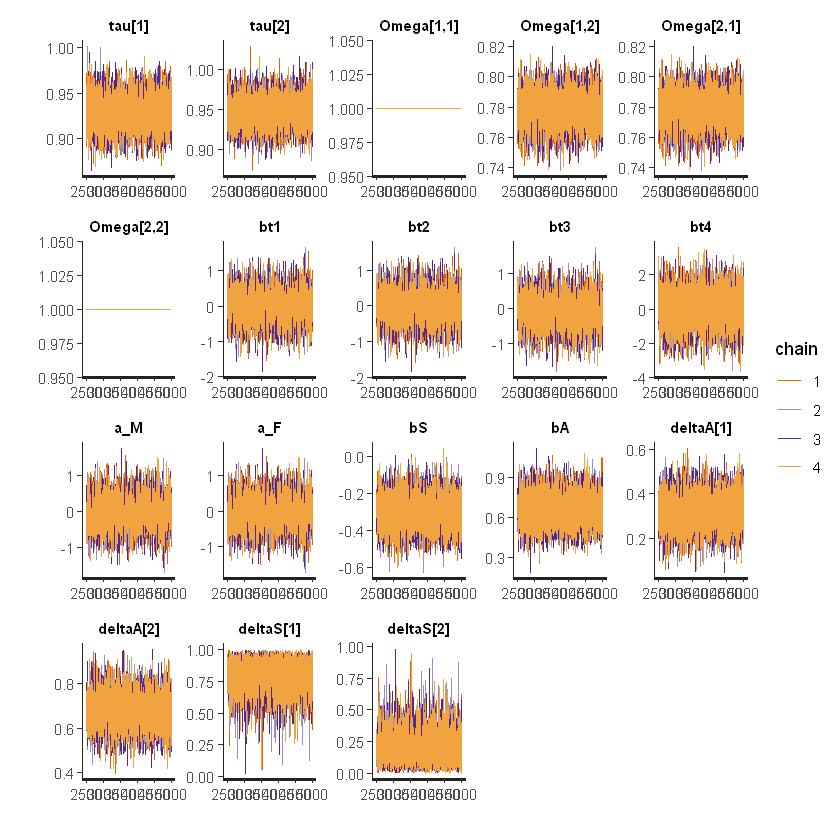

In [39]:
pars = c('tau', 'Omega', 'bt1', 'bt2', 'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS')

stan_trace(model_3, pars = pars)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


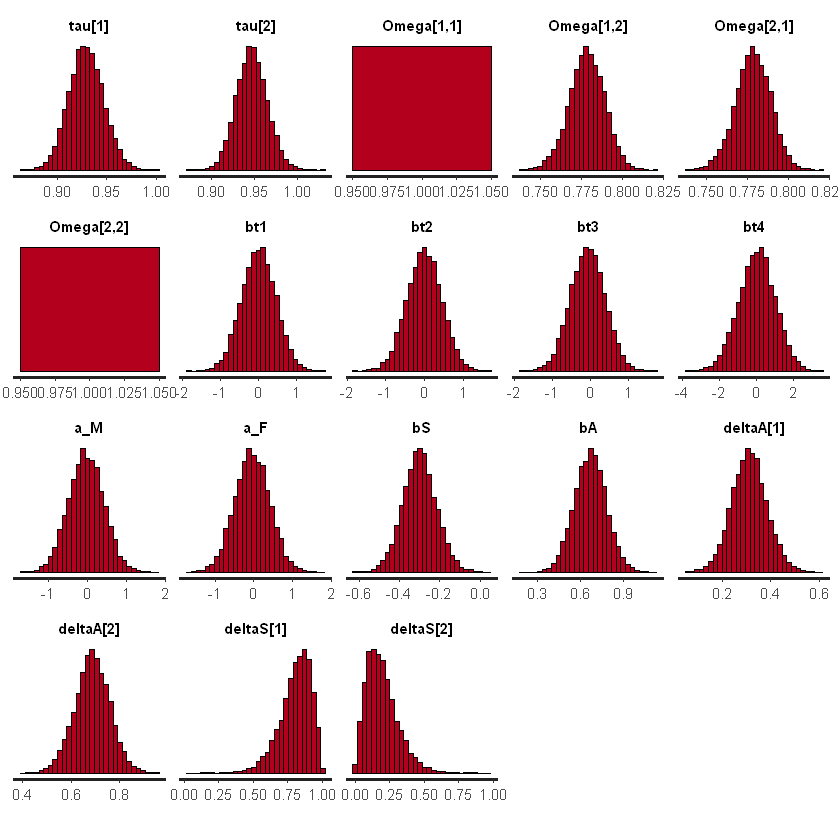

In [40]:
stan_hist(model_3, pars = pars)

In [41]:
loo_1 <- loo(model_1)

loo_2 <- loo(model_2)

loo_3 <- loo(model_3)


comp <- loo_compare(loo_1, loo_2, loo_3)
print(comp, simplify=FALSE)

       elpd_diff se_diff elpd_loo se_elpd_loo p_loo   se_p_loo looic   se_looic
model3     0.0       0.0 -3051.9     35.0         9.9     0.3   6103.8    70.1 
model1  -634.8      28.9 -3686.7     39.9        13.2     0.5   7373.5    79.8 
model2  -635.0      29.0 -3686.9     39.9        13.7     0.5   7373.8    79.7 


All of our first three models are confident of a negative effect corresponding to section numbering, with most of this effect coming from the transition from section 1 to section 2. A stronger positive effect for academic selection is also picked up (as we would expect). None of the models think there is much difference between teachers, but there is a lot of uncertainty about the values of the 'teacher' parameters. Loo prefers the model with correlated exam results and where teacher performance is unified across both exams.

## 10. Revisiting the dropping of absents <a id='abs'></a>

We'll now rerun our third Bayesian model with a modified dataset. Here we do not drop the incomplete cases but instead assign NAs to 0. So students who were absent in an exam now are recorded as scoring zero in it. This approach has its own drawbacks. For one thing, as discussed in the first notebook, even poor students are unlikely to get 0 on an exam. In addition, a student dropping out before the midterm will also be marked as absent for the final, so a teacher taking over that students section will have a zero score for one of their students even though they never taught that student. But since none of our models detect any significant effect of teacher on student outcomes (relative to the other teachers), this should not be problem. 

In [42]:
df_abs <- df_base
df_abs[is.na(df_abs)] <- 0
df_abs <- df_abs[!df_abs$Repeat == 1,]

for (y in 1 : num_years){
  index <- df_abs$Year == y
  m_1 <- mean(df_abs$Midterm[index])
  m_2 <- mean(df_abs$Final[index])  
  s_1 <- sd(df_abs$Midterm[index])
  s_2 <- sd(df_abs$Final[index])
  df_abs$Midterm_std[index] <- ( df_abs$Midterm[index] - m_1 )/s_1
  df_abs$Final_std[index] <- ( df_abs$Final[index] - m_2 )/s_2  
    }

str(df_abs)

'data.frame':	1413 obs. of  9 variables:
 $ Section    : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm    : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final      : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std: num  1.922 1.349 -0.292 0.568 0.255 ...
 $ Final_std  : num  1.351 0.985 -0.371 0.985 0.881 ...


In [43]:
df_abs_full <- df_abs

df_abs_full$M_t1 <- ifelse(df_abs_full$Teacher_M == 1, 1, 0)
df_abs_full$M_t2 <- ifelse(df_abs_full$Teacher_M == 2, 1, 0)
df_abs_full$M_t3 <- ifelse(df_abs_full$Teacher_M == 3, 1, 0)
df_abs_full$M_t4 <- ifelse(df_abs_full$Teacher_M == 4, 1, 0)

df_abs_full$F_t1 <- ifelse(df_abs_full$Teacher_F == 1, 1, 0)
df_abs_full$F_t2 <- ifelse(df_abs_full$Teacher_F == 2, 1, 0)
df_abs_full$F_t3 <- ifelse(df_abs_full$Teacher_F == 3, 1, 0)
df_abs_full$F_t4 <- ifelse(df_abs_full$Teacher_F == 4, 1, 0)

df_abs_full$Stream_level <- ifelse(df_abs_full$Section == 1 & df_abs_full$Year < 5, 3., ifelse(df_abs_full$Year < 5, 1., 2. ))

str(df_abs_full)

'data.frame':	1413 obs. of  18 variables:
 $ Section     : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm     : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final       : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M   : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std : num  1.922 1.349 -0.292 0.568 0.255 ...
 $ Final_std   : num  1.351 0.985 -0.371 0.985 0.881 ...
 $ M_t1        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t2        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ M_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t1        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ F_t2        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Stream_level: num  3 1 1 1 1 1 1 3 1 1 ...


In [44]:
dat_abs <- list(
  N = 1413,
  E = matrix(c(df_abs_full$Midterm_std, df_abs_full$Final_std), ncol = 2),
  
  M_t1 = df_abs_full$M_t1, 
  M_t2 = df_abs_full$M_t2,
  M_t3 = df_abs_full$M_t3, 
  M_t4 = df_abs_full$M_t4,  
  
  F_t1 = df_abs_full$F_t1, 
  F_t2 = df_abs_full$F_t2,
  F_t3 = df_abs_full$F_t3, 
  F_t4 = df_abs_full$F_t4,
    
  A = df_abs_full$Stream_level, 
  S = df_abs_full$Section,
  alpha = rep( 2 , 2 ) 
)

str(dat_abs)

List of 13
 $ N    : num 1413
 $ E    : num [1:1413, 1:2] 1.922 1.349 -0.292 0.568 0.255 ...
 $ M_t1 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ M_t2 : num [1:1413] 1 1 1 1 1 1 1 1 1 1 ...
 $ M_t3 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ M_t4 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t1 : num [1:1413] 1 1 1 1 1 1 1 1 1 1 ...
 $ F_t2 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t3 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t4 : num [1:1413] 0 0 0 0 0 0 0 0 0 0 ...
 $ A    : num [1:1413] 3 1 1 1 1 1 1 3 1 1 ...
 $ S    : int [1:1413] 1 3 2 3 3 3 2 1 2 3 ...
 $ alpha: num [1:2] 2 2


In [45]:
model_4 <- stan( model_code = code_3 , data = dat_abs , chains=4, 
                 cores = 4, iter = num_iters )

In [46]:
results_4 <- summary(model_4, probs = c(0.025, 0.975), 
                     pars = c('tau', 'Omega', 'bt1', 'bt2', 
                              'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_4

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.93079215,0.0002397089,0.017852935,0.89650310,0.96635233,5546.906,0.9998813
tau[2],0.94793329,0.0002379995,0.017980279,0.91304749,0.98402821,5707.431,0.9998256
"Omega[1,1]",1.00000000,NaN,0.000000000,1.00000000,1.00000000,NaN,NaN
"Omega[1,2]",0.79560529,0.0001287311,0.009816852,0.77594054,0.81424134,5815.374,0.9997502
"Omega[2,1]",0.79560529,0.0001287311,0.009816852,0.77594054,0.81424134,5815.374,0.9997502
"Omega[2,2]",1.00000000,NaN,0.000000000,1.00000000,1.00000000,NaN,NaN
bt1,-0.01820990,0.0087092427,0.446971824,-0.88443225,0.84321755,2633.901,1.0004752
bt2,-0.05303489,0.0087296768,0.448535445,-0.92532757,0.81490207,2639.959,1.0004628
bt3,-0.02676723,0.0087338332,0.456086318,-0.92454462,0.86006014,2726.995,1.0004317
bt4,0.01137546,0.0096613084,0.994763744,-1.92342360,1.95809725,10601.517,0.9998440


In [47]:
samples <- extract(model_4, 'bS') 
counts <- ifelse(samples$bS < -0.1, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.1:", p, sep = " ")

samples <- extract(model_4, 'bS') 
counts <- ifelse(samples$bS < -0.05, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.05:", p, sep = " ")

[1] "Proportion less than -0.1: 0.9583"

[1] "Proportion less than -0.05: 0.9888"

The results here are similar to the others. The model is confident of an effect of section numbering, mostly in the transition from section 1 to section 2. It is not confident of any difference in the influence of the teachers, but there is high uncertainty on this point. 

## 11. Dropping year 5 <a id='five'></a>
Looking at the [charts](#chart) showing section performance by year from an earlier cell, we see that year 5 is something of an outlier in that section 1 did much better than section 2 in both exams, even though they were not academically selected that year. It's unclear what caused this, and, interestingly, the first notebook shows the opposite relationship for the same cohort of students in the following year. We may suspect that much of the detected effect of section number on performance detected by our models here comes from this year. Indeed this is the case, as the first model retrained on data omitting that year indicates (see below). However, it's not clear from this which model we should believe. Year 5 is an outlier, but it is something that happened. It's not a data entry error, and nothing obviously unusual occurred that year that would ordinarily cause us to be skeptical of that data.

In [48]:
index <- df_abs_full$Year == 5
df_no_5 <- df_abs_full[!index,]
str(df_no_5)

'data.frame':	1324 obs. of  18 variables:
 $ Section     : int  1 3 2 3 3 3 2 1 2 3 ...
 $ Midterm     : num  75 64 32.5 49 43 42.5 72.5 79.5 50.5 53 ...
 $ Final       : num  62 55 29 55 53 47 58 68 41 9 ...
 $ Year        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Repeat      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Teacher_M   : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Teacher_F   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Midterm_std : num  1.922 1.349 -0.292 0.568 0.255 ...
 $ Final_std   : num  1.351 0.985 -0.371 0.985 0.881 ...
 $ M_t1        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t2        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ M_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ M_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t1        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ F_t2        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t3        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ F_t4        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Stream_level: num  3 1 1 1 1 1 1 3 1 1 ...


In [49]:
dat_no_5 <- list(
  N = 1324,
  E = matrix(c(df_no_5$Midterm_std, df_no_5$Final_std), ncol=2),
  
  # indicator variables for teachers in midterm
  M_t1 = df_no_5$M_t1, 
  M_t2 = df_no_5$M_t2,
  M_t3 = df_no_5$M_t3, 
  M_t4 = df_no_5$M_t4,  
  
  # indicator variables for teachers in final
  F_t1 = df_no_5$F_t1, 
  F_t2 = df_no_5$F_t2,
  F_t3 = df_no_5$F_t3, 
  F_t4 = df_no_5$F_t4,     
  A = df_no_5$Stream_level, # discrete ordered predictor for 3 levels of streaming
  S = df_no_5$Section, # section number
  alpha = rep( 2 , 2 ) # parameters for Dirichlet priors
)

str(dat_no_5)

List of 13
 $ N    : num 1324
 $ E    : num [1:1324, 1:2] 1.922 1.349 -0.292 0.568 0.255 ...
 $ M_t1 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ M_t2 : num [1:1324] 1 1 1 1 1 1 1 1 1 1 ...
 $ M_t3 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ M_t4 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t1 : num [1:1324] 1 1 1 1 1 1 1 1 1 1 ...
 $ F_t2 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t3 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ F_t4 : num [1:1324] 0 0 0 0 0 0 0 0 0 0 ...
 $ A    : num [1:1324] 3 1 1 1 1 1 1 3 1 1 ...
 $ S    : int [1:1324] 1 3 2 3 3 3 2 1 2 3 ...
 $ alpha: num [1:2] 2 2


In [50]:
model_5 <- stan( model_code = code_3 , data = dat_no_5 , chains=4, 
                 cores = 4, iter = num_iters )

In [51]:
results_5 <- summary(model_5, probs = c(0.025, 0.975), 
                     pars = c('tau', 'Omega', 'bt1', 'bt2', 
                              'bt3', 'bt4', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_5

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.93081850,0.0002443470,0.018089660,0.8965758,0.96668577,5480.838,1.0005482
tau[2],0.94502332,0.0002475243,0.018455887,0.9097020,0.98182724,5559.479,1.0005276
"Omega[1,1]",1.00000000,NaN,0.000000000,1.0000000,1.00000000,NaN,NaN
"Omega[1,2]",0.80242158,0.0001284640,0.009773063,0.7827172,0.82108396,5787.599,1.0005282
"Omega[2,1]",0.80242158,0.0001284640,0.009773063,0.7827172,0.82108396,5787.599,1.0005282
"Omega[2,2]",1.00000000,NaN,0.000000000,1.0000000,1.00000000,NaN,NaN
bt1,-0.09586873,0.0091553141,0.453456840,-0.9537932,0.80073926,2453.157,1.0030448
bt2,-0.04815427,0.0091235192,0.454192766,-0.9120234,0.83705535,2478.310,1.0030379
bt3,-0.07728133,0.0092719634,0.461934308,-0.9666778,0.83171746,2482.087,1.0027528
bt4,-0.01300312,0.0099600842,0.994582112,-1.9274667,1.93058632,9971.380,0.9996794


In [52]:
samples <- extract(model_5, 'bS') 
counts <- ifelse(samples$bS < -0.05, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.05:", p, sep = " ")

samples <- extract(model_5, 'bS') 
counts <- ifelse(samples$bS < -0.01, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than -0.01:", p, sep = " ")

samples <- extract(model_5, 'bS') 
counts <- ifelse(samples$bS < 0, 1, 0)
p <- sum(counts)/length(counts)
paste("Proportion less than 0:", p, sep = " ")

[1] "Proportion less than -0.05: 0.7903"

[1] "Proportion less than -0.01: 0.9086"

[1] "Proportion less than 0: 0.9293"

This model has significantly less confidence about the negative influence of section numbering, as we might expect, though the majority of the probability mass for the $\beta_S$ parameter remains less than zero. In addition, the model is less confident about the relative importance of going from section 1 to 2 compared to from section 2 to 3.

As discussed above, while the results from year 5 are clearly something of an outlier, there does not appear to be a compelling reason to exclude them. In addition, comparing our models, they seem to exaggerate the trend obtained from the rest of the data, but they do not change its direction entirely. 

## 12. Model without teacher influence <a id='no_T'></a>
We now drop the teacher information from the model based on the [third model](#model3) from [part 9.](#bayes).

In [53]:
dat_no_T <- list(
  N = 1359,
  E = matrix(c(df_full$Midterm_std, df_full$Final_std), ncol = 2),   
  A = df_full$Stream_level, # discrete ordered predictor for 3 levels of streaming
  S = df_full$Section, # section number
  alpha = rep( 2 , 2 ) # parameters for Dirichlet priors
)

str(dat_no_T)

List of 5
 $ N    : num 1359
 $ E    : num [1:1359, 1:2] 1.932 1.329 -0.399 0.506 0.177 ...
 $ A    : num [1:1359] 3 1 1 1 1 1 1 3 1 1 ...
 $ S    : int [1:1359] 1 3 2 3 3 3 2 1 2 3 ...
 $ alpha: num [1:2] 2 2


In [54]:
code_4 <- 'data{
    int N;
    array[N] vector[2] E;
    int S[N];
    int A[N];
    vector[2] alpha;
}
parameters{
    corr_matrix[2] Omega;     
    vector<lower=0>[2] tau;
    real a_F;
    real a_M;
    real bS;
    real bA;
    simplex[2] deltaA;
    simplex[2] deltaS;
    
}

transformed parameters{
vector[3] deltaA_j;
vector[3] deltaS_j;
deltaS_j = append_row(0, deltaS);
deltaA_j = append_row(0, deltaA);
}

model{
    tau ~ lognormal( 0, 0.25 );
    Omega ~ lkj_corr(2);
    array[N] vector[2] mu;
    a_M ~ normal( 0 , 1 );
    a_F ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    bS ~ normal( 0 , 1 );
    deltaS ~ dirichlet( alpha );
    deltaA ~ dirichlet( alpha );
    for ( i in 1:N ) {
        mu[i][1] = a_M + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu[i][2] = a_F + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
    }

    E ~ multi_normal(mu, quad_form_diag(Omega, tau));
}

generated quantities{
    vector[N] log_lik; 
    array[N] vector[2] mu;
    for ( i in 1:N ) {
        mu[i][1] = a_M + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        mu[i][2] = a_F + bA*sum(deltaA_j[1:A[i]]) + bS*sum(deltaS_j[1:S[i]]);
        log_lik[i] = multi_normal_lpdf(E[i] | mu[i] , quad_form_diag(Omega, tau) );
    }
}

'

In [55]:
model_6 <- stan( model_code = code_4 , data = dat_no_T , chains=4, 
                 cores = 4, iter = num_iters )

In [56]:
results_6 <- summary(model_6, probs = c(0.025, 0.975), 
                     pars = c('tau', 'Omega', 'a_M', 'a_F', 
                              'bS', 'bA', 'deltaA', 'deltaS'))$summary
results_6

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.9284734,0.0002245281,0.01763420,0.89461416,0.9633715,6168.369,0.9999923
tau[2],0.9461575,0.0002287026,0.01788764,0.91118805,0.9815681,6117.359,0.9998330
"Omega[1,1]",1.0000000,NaN,0.00000000,1.00000000,1.0000000,NaN,NaN
"Omega[1,2]",0.7782284,0.0001341169,0.01063970,0.75635706,0.7979684,6293.495,1.0002586
"Omega[2,1]",0.7782284,0.0001341169,0.01063970,0.75635706,0.7979684,6293.495,1.0002586
"Omega[2,2]",1.0000000,NaN,0.00000000,1.00000000,1.0000000,NaN,NaN
a_M,-0.0398416,0.0016403451,0.08767357,-0.21089620,0.1290226,2856.715,1.0010268
a_F,-0.0397220,0.0016546573,0.08806113,-0.21154362,0.1294784,2832.385,1.0009602
bS,-0.3000727,0.0014511996,0.08209400,-0.45856541,-0.1374670,3200.137,1.0004443
bA,0.6720270,0.0017877943,0.10376204,0.47195408,0.8793213,3368.542,1.0008871


These results are consistent with our previous ones for the same data.

## 13. A model without section information <a id='no_sec'></a>
Finally we train a model without section information either. We will compare our first three and last two models using loo (we cannot include the other two models as they are based on different numbers of students).

In [57]:
code_5 <- 'data{
    int N;
    array[N] vector[2] E;
    int A[N];
    vector[2] alpha;
}
parameters{
    corr_matrix[2] Omega;     
    vector<lower=0>[2] tau;
    real a_F;
    real a_M;
    real bA;
    simplex[2] deltaA;
    
}

transformed parameters{
vector[3] deltaA_j;
deltaA_j = append_row(0, deltaA);
}

model{
    tau ~ lognormal( 0, 0.25 );
    Omega ~ lkj_corr(2);
    array[N] vector[2] mu;
    a_M ~ normal( 0 , 1 );
    a_F ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    deltaA ~ dirichlet( alpha );
    for ( i in 1:N ) {
        mu[i][1] = a_M + bA*sum(deltaA_j[1:A[i]]);
        mu[i][2] = a_F + bA*sum(deltaA_j[1:A[i]]);
    }

    E ~ multi_normal(mu, quad_form_diag(Omega, tau));
}

generated quantities{
    vector[N] log_lik; 
    array[N] vector[2] mu;
    for ( i in 1:N ) {
        mu[i][1] = a_M + bA*sum(deltaA_j[1:A[i]]);
        mu[i][2] = a_F + bA*sum(deltaA_j[1:A[i]]);
        log_lik[i] = multi_normal_lpdf(E[i] | mu[i] , quad_form_diag(Omega, tau) );
    }
}

'

In [58]:
model_7 <- stan( model_code = code_5 , data = dat_no_T , chains=4, 
                 cores = 4, iter = num_iters )

In [59]:
results_7 <- summary(model_7, probs = c(0.025, 0.975), 
                     pars = c('tau', 'Omega', 'a_M', 'a_F', 'bA', 'deltaA'))$summary
results_7

,mean,se_mean,sd,2.5%,97.5%,n_eff,Rhat
tau[1],0.9340069,0.0002244007,0.01771293,0.8997735,0.9694801,6230.636,1.0000277
tau[2],0.9475059,0.0002276861,0.01805616,0.9129146,0.9837501,6288.950,1.0002264
"Omega[1,1]",1.0000000,NaN,0.00000000,1.0000000,1.0000000,NaN,NaN
"Omega[1,2]",0.7799219,0.0001378453,0.01061537,0.7584617,0.8002688,5930.428,0.9999694
"Omega[2,1]",0.7799219,0.0001378453,0.01061537,0.7584617,0.8002688,5930.428,0.9999694
"Omega[2,2]",1.0000000,NaN,0.00000000,1.0000000,1.0000000,NaN,NaN
a_M,-0.3102416,0.0006135544,0.04076523,-0.3893732,-0.2293074,4414.421,1.0010085
a_F,-0.3102646,0.0006035785,0.04095276,-0.3895651,-0.2298877,4603.614,1.0008956
bA,0.9412293,0.0009280171,0.06911687,0.8066027,1.0780400,5546.975,1.0009402
deltaA[1],0.3320215,0.0006425345,0.05072884,0.2330837,0.4336779,6233.286,0.9999624


In [60]:
loo_6 <- loo(model_6)

loo_7 <- loo(model_7)


comp <- loo_compare(loo_1, loo_2, loo_3, loo_6, loo_7)
print(comp, simplify=FALSE)

       elpd_diff se_diff elpd_loo se_elpd_loo p_loo   se_p_loo looic   se_looic
model4     0.0       0.0 -3050.2     35.1         8.2     0.3   6100.5    70.1 
model3    -1.7       0.6 -3051.9     35.0         9.9     0.3   6103.8    70.1 
model5    -5.4       3.9 -3055.7     35.0         6.7     0.3   6111.3    70.0 
model1  -636.5      28.9 -3686.7     39.9        13.2     0.5   7373.5    79.8 
model2  -636.7      29.0 -3686.9     39.9        13.7     0.5   7373.8    79.7 


Loo shows a slight preference for the model that includes section information, but that excludes teacher information.

## 14. Conclusions <a id='conc'></a>

Unlike in the previous notebook, the best models here are confident of a small negative influence of section number on exam performance. The obvious thing to do here to resolve the difference of opinion would be to combine our two datasets together and run a more sophisticated model involving all the data simultaneously. This will be done in the next notebook, and I will defer a more in-depth discussion of the results till then.